In [2]:
import polars as pl
import os
from pathlib import Path
import pandas as pd
import hvplot.polars
import datetime
import matplotlib.pyplot as plt
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

# option_data = Path.cwd().parent.parent / "Data/Modeling/sso_new.csv"
# df = pl.scan_csv(option_data, separator=",")

parquet_file = ('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/total_dataset.parquet')
 
data_path = Path.cwd().parent / "Data"

#Restrictions
timeperiod = [datetime.datetime(2019, 1, 1), datetime.datetime(2021, 12, 31)]
volume_r = 0
open_interest_r = 0
delta_r = 0
vega_r = 0
theta_r = 0
gamma_r = 0
midprice_r = 0.3
bid_price_r = 0.0
days_till_exp_r1 = 7
days_till_exp_r2 = 252
moneyness_min = 0.8         
moneyness_max = 1.6

firm_stock_data = Path.cwd().parent.parent / "Data/updated_standardization/firm_stock_dataset_tech.parquet"
macro_data = Path.cwd().parent.parent / "Data/updated_standardization/data_set_macro.parquet"


firm_stock_data = pd.read_parquet(firm_stock_data)
df_all = pd.read_parquet(parquet_file)
macro_data = pd.read_parquet(macro_data)

# Small adjustments
df_all.loc[df_all['trading_days_till_exp'] == 0, 'trading_days_till_exp'] = 1
df_all['cp_flag'] = df_all['cp_flag'].map({'C': 1, 'P': 0})
df_all['T'] = df_all['trading_days_till_exp'] / 252

# Add the following columns for ADHOC
df_all['moneyness_squared'] = df_all['moneyness'] ** 2
df_all['tau_squared'] = df_all['T'] ** 2
df_all['moneyness_tau'] = df_all['moneyness'] * df_all['T']
df_all['prc_option'] = (df_all['best_offer'] + df_all['best_bid']) / 2
df_all['spread_option'] = (df_all['best_offer'] - df_all['best_bid'])
df_all['hi-lo_stock'] = (df_all['ASKHI'] - df_all['BIDLO'])
# df_all = df_all[df_all['prc_option'] > 0.125]

# List of columns to drop
columns_to_drop = ['divi', 'divo', 'sin', 'RETX', 'BIDLO', 'ASKHI', 'cumulative_return', 'prev_day_iv', 'prev2_day_iv', 'HIGH_vix', 'LOW_vix', 'best_bid_option', 'best_offer_option', 'OPEN_vix']

indicator_features = ['ticker_AAPL', 'ticker_AMZN','ticker_META', 'ticker_MSFT', 'ticker_NVDA', 'ticker_TSLA', 'daily_return_indicator_stock', 'cp_flag' ]

collumns_exclude = indicator_features + ['Ticker', 'impl_volatility', 'date', 'impl_volatility_h_1_step', 'impl_volatility_h_5_step']

# Drop columns from datasets if they exist
firm_stock_data = firm_stock_data.drop(columns=columns_to_drop, errors='ignore')
option_data1 = df_all.drop(columns=columns_to_drop, errors='ignore')
macro_data = macro_data.drop(columns=columns_to_drop, errors='ignore')

# Rename column
macro_data = macro_data.rename(columns={'spread_vix': 'hi-lo_vix'})


In [3]:
firm_stock_data = firm_stock_data.iloc[:, :12]
firm_stock_data

,Ticker,date,PRC,vol_stock,RET,BID,ASK,PRC_actual,daily_return_indicator_stock,5_day_rolling_return_stock,hi-lo_stock,spread_stock
0,AAPL,2019-01-02,156.23000,42291347.0,0.000512,156.22000,156.24001,39.057500,1.0,-0.003826,3.97000,0.02001
1,AAPL,2019-01-03,157.74001,35003466.0,0.009665,157.92999,157.94000,39.435003,1.0,0.046507,2.88000,0.01001
2,AAPL,2019-01-04,157.92000,37066356.0,0.001141,157.91000,157.92999,39.480000,1.0,0.075529,4.62001,0.01999
3,AAPL,2019-01-07,142.19000,91373695.0,-0.099607,142.08000,142.09000,35.547500,-1.0,-0.095311,3.72000,0.01000
4,AAPL,2019-01-08,148.25999,58603001.0,0.042689,148.25000,148.25999,37.064997,1.0,-0.050529,4.74990,0.00999
...,...,...,...,...,...,...,...,...,...,...,...,...
6051,TSLA,2021-12-27,1008.87000,31046563.0,0.074947,1008.50000,1008.87000,336.290000,1.0,0.033689,58.60992,0.37000
6052,TSLA,2021-12-28,1067.00000,30735097.0,0.057619,1067.45996,1067.58997,355.666667,1.0,0.151125,75.41668,0.13001
6053,TSLA,2021-12-29,1093.93994,23695249.0,0.025248,1093.81995,1093.83997,364.646647,1.0,0.173038,46.28479,0.02002
6054,TSLA,2021-12-30,1088.46997,20025526.0,-0.005000,1088.68005,1089.19995,362.823323,-1.0,0.209492,40.57984,0.51990


In [4]:
df_all = df_all[df_all['prc_option'] >= 0.125]
df_all

,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,...,Forward_Price,moneyness,trading_day,maturity_group,m_category,moneyness_squared,tau_squared,moneyness_tau,spread_option,hi-lo_stock
3627,2018-12-31,2019-01-04,0,103000,2.79,2.92,499,2070,48.6343,-0.596821,...,100.420411,0.974660,1,Short,"[0.97, 1.03]",0.949962,0.000142,0.011603,0.13,2.89
3626,2018-12-31,2019-01-04,0,102000,2.18,2.47,1455,575,49.7933,-0.520280,...,100.420411,0.984216,1,Short,"[0.97, 1.03]",0.968681,0.000142,0.011717,0.29,2.89
3625,2018-12-31,2019-01-04,0,101000,1.64,1.70,2502,703,46.1807,-0.442281,...,100.420411,0.993960,1,Short,"[0.97, 1.03]",0.987957,0.000142,0.011833,0.06,2.89
3624,2018-12-31,2019-01-04,0,100000,1.21,1.25,6804,2149,45.7006,-0.361574,...,100.420411,1.003900,1,Short,"[0.97, 1.03]",1.007815,0.000142,0.011951,0.04,2.89
3623,2018-12-31,2019-01-04,1,99500,2.38,2.46,407,692,25.1778,0.789363,...,100.420411,1.008945,1,Short,"[0.97, 1.03]",1.017969,0.000142,0.012011,0.08,2.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5850930,2022-01-06,2022-01-07,1,315000,1.79,1.84,12713,466,35.4934,0.427943,...,NaN,0.996381,762,Short,"[0.97, 1.03]",0.992775,0.000016,0.003954,0.05,NaN
5850931,2022-01-06,2022-01-07,1,317500,0.91,0.97,19097,775,35.0718,0.269449,...,NaN,0.988535,762,Short,"[0.97, 1.03]",0.977202,0.000016,0.003923,0.06,NaN
5850932,2022-01-06,2022-01-07,1,320000,0.44,0.46,46482,2919,35.3525,0.150725,...,NaN,0.980813,762,Short,"[0.97, 1.03]",0.961993,0.000016,0.003892,0.02,NaN
5850933,2022-01-06,2022-01-07,1,322500,0.22,0.23,10100,3451,36.9277,0.082080,...,NaN,0.973209,762,Short,"[0.97, 1.03]",0.947136,0.000016,0.003862,0.01,NaN


In [5]:
# Merge option_data1 and firm_stock_data
option_data = pd.merge(option_data1, firm_stock_data, on=['date', 'Ticker'], how='left', suffixes=('', '_firm'))

# Merge the result with macro_data
option_data_total = pd.merge(option_data, macro_data, on=['date'], how='left', suffixes=('', '_macro'))

# Remove duplicate columns that were created during the merge
for col in option_data_total.columns:
    if col.endswith('_firm') or col.endswith('_macro'):
        base_col = col.rsplit('_', 1)[0]
        if base_col in option_data_total.columns:
            option_data_total.drop(columns=[col], inplace=True)
        else:
            option_data_total.rename(columns={col: base_col}, inplace=True)

# Ensure only distinct column names
option_data_total = option_data_total.loc[:, ~option_data_total.columns.duplicated()]


In [6]:
df_all = option_data_total

# Move the 'Ticker' column to the second position
cols = list(df_all.columns)
cols.insert(2, cols.pop(cols.index('Ticker')))
df_all = df_all[cols]

# Divide the 'impl_volatility' column by 100
df_all['impl_volatility'] = df_all['impl_volatility'] / 100

df_all

,date,exdate,Ticker,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,...,daily_return_indicator_stock,5_day_rolling_return_stock,spread_stock,FF_rate,gold_price,reces_indi,10Y_RIR,1Y_bond,CLOSE_vix,hi-lo_vix
0,2018-12-31,2019-01-04,MSFT,0,103000,2.79,2.92,499,2070,0.486343,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-12-31,2019-01-04,MSFT,0,102000,2.18,2.47,1455,575,0.497933,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-12-31,2019-01-04,MSFT,0,101000,1.64,1.70,2502,703,0.461807,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-12-31,2019-01-04,MSFT,0,100000,1.21,1.25,6804,2149,0.457006,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-12-31,2019-01-04,MSFT,1,99500,2.38,2.46,407,692,0.251778,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412627,2022-01-06,2022-01-07,MSFT,1,315000,1.79,1.84,12713,466,0.354934,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
412628,2022-01-06,2022-01-07,MSFT,1,317500,0.91,0.97,19097,775,0.350718,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
412629,2022-01-06,2022-01-07,MSFT,1,320000,0.44,0.46,46482,2919,0.353525,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
412630,2022-01-06,2022-01-07,MSFT,1,322500,0.22,0.23,10100,3451,0.369277,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df_all = df_all[df_all['prc_option'] >= 0.125]

In [8]:
import pandas as pd

# Step 1: Identify dates with multiple unique 'T' values
maturity_counts = df_all.groupby('date')['T'].nunique().reset_index(name='unique_maturities')

# Step 2: Filter dates where there are two or more unique maturities
dates_with_differences = maturity_counts[maturity_counts['unique_maturities'] > 1]['date']

# Step 3: Remove rows with T > 0.01 for the identified dates
df_filtered = df_all[~((df_all['date'].isin(dates_with_differences)) & (df_all['T'] > 0.01))]

# Display the filtered DataFrame
print("Filtered DataFrame:")
df_filtered


Filtered DataFrame:


,date,exdate,Ticker,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,...,daily_return_indicator_stock,5_day_rolling_return_stock,spread_stock,FF_rate,gold_price,reces_indi,10Y_RIR,1Y_bond,CLOSE_vix,hi-lo_vix
0,2018-12-31,2019-01-04,MSFT,0,103000,2.79,2.92,499,2070,0.486343,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-12-31,2019-01-04,MSFT,0,102000,2.18,2.47,1455,575,0.497933,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-12-31,2019-01-04,MSFT,0,101000,1.64,1.70,2502,703,0.461807,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-12-31,2019-01-04,MSFT,0,100000,1.21,1.25,6804,2149,0.457006,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-12-31,2019-01-04,MSFT,1,99500,2.38,2.46,407,692,0.251778,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412627,2022-01-06,2022-01-07,MSFT,1,315000,1.79,1.84,12713,466,0.354934,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
412628,2022-01-06,2022-01-07,MSFT,1,317500,0.91,0.97,19097,775,0.350718,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
412629,2022-01-06,2022-01-07,MSFT,1,320000,0.44,0.46,46482,2919,0.353525,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
412630,2022-01-06,2022-01-07,MSFT,1,322500,0.22,0.23,10100,3451,0.369277,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
import pandas as pd

# Group by date and count unique values of 'T' (maturities) for each date
maturity_counts = df_filtered.groupby('date')['T'].nunique().reset_index(name='unique_maturities')

# Filter dates where there are two or more unique maturities
dates_with_differences = maturity_counts[maturity_counts['unique_maturities'] > 1]

# Display the results
print("Dates with different maturities:")
print(dates_with_differences)

df_all = df_filtered

Dates with different maturities:
Empty DataFrame
Columns: [date, unique_maturities]
Index: []


In [11]:
df_all

,date,exdate,Ticker,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,...,daily_return_indicator_stock,5_day_rolling_return_stock,spread_stock,FF_rate,gold_price,reces_indi,10Y_RIR,1Y_bond,CLOSE_vix,hi-lo_vix
0,2018-12-31,2019-01-04,MSFT,0,103000,2.79,2.92,499,2070,0.486343,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-12-31,2019-01-04,MSFT,0,102000,2.18,2.47,1455,575,0.497933,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-12-31,2019-01-04,MSFT,0,101000,1.64,1.70,2502,703,0.461807,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-12-31,2019-01-04,MSFT,0,100000,1.21,1.25,6804,2149,0.457006,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-12-31,2019-01-04,MSFT,1,99500,2.38,2.46,407,692,0.251778,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412627,2022-01-06,2022-01-07,MSFT,1,315000,1.79,1.84,12713,466,0.354934,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
412628,2022-01-06,2022-01-07,MSFT,1,317500,0.91,0.97,19097,775,0.350718,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
412629,2022-01-06,2022-01-07,MSFT,1,320000,0.44,0.46,46482,2919,0.353525,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
412630,2022-01-06,2022-01-07,MSFT,1,322500,0.22,0.23,10100,3451,0.369277,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# def calculate_previous_iv(df):
#     # Ensure 'date' is sorted
#     df = df.sort_values(['Ticker', 'date'])
    
#     # Calculate dollar volume for each option
#     df['dollar_volume'] = df['volume'] * ((df['best_bid'] + df['best_offer']) / 2)
    
#     # Calculate total implied volatility weighted by dollar volume for each row
#     df['total_iv_weighted'] = df['impl_volatility'] * df['dollar_volume']
    
#     # Group by 'Ticker' and 'date' to calculate daily totals
#     daily_totals = df.groupby(['Ticker', 'date']).agg(
#         total_iv_weighted=('total_iv_weighted', 'sum'),
#         total_dollar_volume=('dollar_volume', 'sum')
#     ).reset_index()

#     # Calculate the previous day's weighted IV for each 'Ticker'
#     daily_totals['previous_iv'] = daily_totals.groupby('Ticker').apply(
#         lambda group: (group['total_iv_weighted'].shift(1) / group['total_dollar_volume'].shift(1))
#     ).reset_index(level=0, drop=True)
    
#     # Merge the previous_iv back to the original dataframe
#     df = df.merge(daily_totals[['Ticker', 'date', 'previous_iv']], on=['Ticker', 'date'], how='left')
    
#     # Fill NaN values with 0
#     df['previous_iv'] = df['previous_iv'].fillna(0)
    
#     # Create a column for each ticker's previous_iv
#     tickers = df['Ticker'].unique()
#     for ticker in tickers:
#         ticker_prev_iv_col = f"{ticker}_prev_iv"
#         df[ticker_prev_iv_col] = df.apply(lambda row: row['previous_iv'] if row['Ticker'] == ticker else np.nan, axis=1)
    
#     return df

# # Apply the function to the dataframe
# df_all = calculate_previous_iv(df_all)


# Small adjustments to the collumns


In [13]:
unique_tickers = df_all['Ticker'].unique()

# Create dummy variables for 'Ticker' column
df = pd.get_dummies(df_all, columns=['Ticker'], prefix='ticker')

# Convert only the dummy columns to integers
dummy_columns = [col for col in df.columns if col.startswith('ticker_')]
df[dummy_columns] = df[dummy_columns].astype(int)

# Ensure 'Ticker' column is not removed
df['Ticker'] = df_all['Ticker']

df_all = df


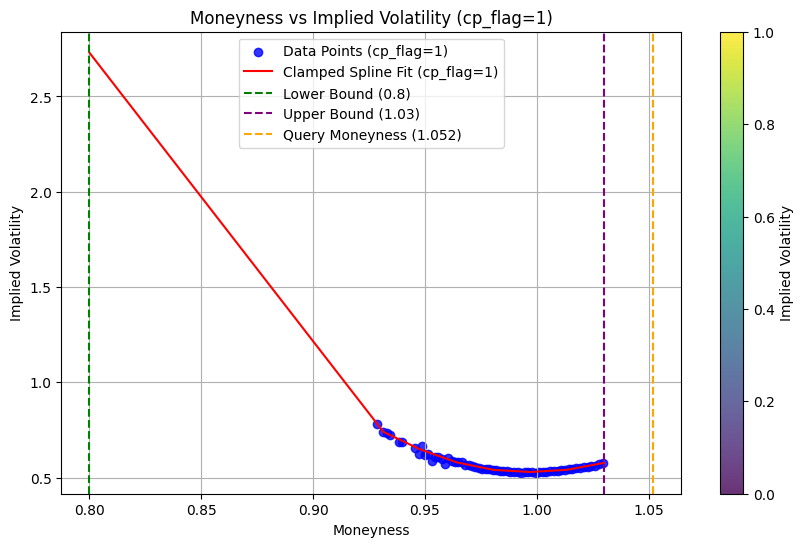

Implied Volatility for moneyness=1.052, cp_flag=1: 0.6183995412928076


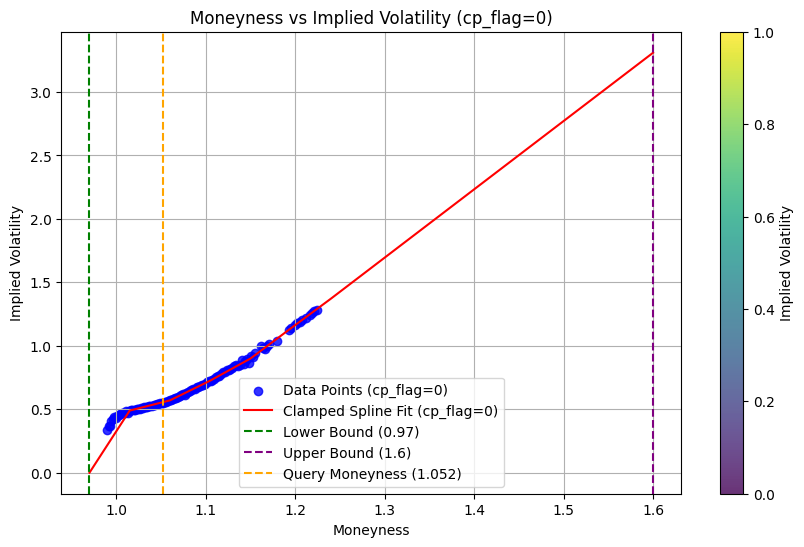

Implied Volatility for moneyness=1.052, cp_flag=0: 0.5503435615908104


In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.interpolate import splrep, splev

# Convert the string to a pandas Timestamp
date = pd.Timestamp('2019-01-03')

# Filter the DataFrame for the 'AMZN' ticker and the specific date
df_amzn = df_all[(df_all['Ticker'] == 'AMZN') & (df_all['date'] == date)]

# Sort the data by moneyness to ensure smooth interpolation
df_amzn = df_amzn.sort_values(by='moneyness')

# Define a function for clamped prediction with dynamic ranges
def predict_iv_clamped(input_moneyness, tck, moneyness_range):
    if input_moneyness < moneyness_range.min():
        # Linear extrapolation for values below the minimum
        slope = (splev(moneyness_range[1], tck) - splev(moneyness_range[0], tck)) / (moneyness_range[1] - moneyness_range[0])
        iv = splev(moneyness_range[0], tck) + slope * (input_moneyness - moneyness_range[0])
    elif input_moneyness > moneyness_range.max():
        # Linear extrapolation for values above the maximum
        slope = (splev(moneyness_range[-1], tck) - splev(moneyness_range[-2], tck)) / (moneyness_range[-1] - moneyness_range[-2])
        iv = splev(moneyness_range[-1], tck) + slope * (input_moneyness - moneyness_range[-1])
    else:
        # Spline interpolation for values within the range
        iv = splev(input_moneyness, tck)
    
    # Ensure IV is non-negative
    return max(iv, 0)

# Function to handle plotting and querying
def process_cp_flag(df_amzn, cp_flag, moneyness_range, input_moneyness):
    # Filter by cp_flag
    df_cp_flag = df_amzn[df_amzn['cp_flag'] == cp_flag]
    if df_cp_flag.empty:
        print(f"No data available for cp_flag={cp_flag}.")
        return None, None

    # Extract moneyness and implied volatility
    moneyness = df_cp_flag['moneyness'].values
    implied_volatility = df_cp_flag['impl_volatility'].values

    if len(moneyness) <= 3:
        print(f"Not enough points for spline fitting (cp_flag={cp_flag}).")
        return None, None

    # Create a spline for this group
    try:
        tck = splrep(moneyness, implied_volatility, k=3, s=0)
    except ValueError as e:
        print(f"Error creating spline for cp_flag={cp_flag}: {e}")
        return None, None

    # Predict the IV for the given moneyness
    iv = predict_iv_clamped(input_moneyness, tck, moneyness)

    # Generate interpolated values for the plot
    implied_volatility_clamped = [predict_iv_clamped(x, tck, moneyness) for x in moneyness_range]

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.scatter(moneyness, implied_volatility, c='blue', label=f'Data Points (cp_flag={cp_flag})', alpha=0.8)
    plt.plot(moneyness_range, implied_volatility_clamped, color='red', label=f'Clamped Spline Fit (cp_flag={cp_flag})')
    plt.axvline(x=moneyness_range.min(), color='green', linestyle='--', label=f'Lower Bound ({moneyness_range.min()})')
    plt.axvline(x=moneyness_range.max(), color='purple', linestyle='--', label=f'Upper Bound ({moneyness_range.max()})')
    plt.axvline(x=input_moneyness, color='orange', linestyle='--', label=f'Query Moneyness ({input_moneyness})')
    plt.colorbar(label='Implied Volatility')
    plt.xlabel('Moneyness')
    plt.ylabel('Implied Volatility')
    plt.title(f'Moneyness vs Implied Volatility (cp_flag={cp_flag})')
    plt.legend()
    plt.grid(True)
    plt.show()

    return tck, iv

# Example usage
input_moneyness = 1.052  # Example moneyness value

# Process cp_flag = 1 (Call options)
tck_1, iv_cp_flag_1 = process_cp_flag(
    df_amzn, 
    cp_flag=1, 
    moneyness_range=np.linspace(0.8, 1.03, 15), 
    input_moneyness=input_moneyness
)
if iv_cp_flag_1 is not None:
    print(f"Implied Volatility for moneyness={input_moneyness}, cp_flag=1: {iv_cp_flag_1}")

# Process cp_flag = 0 (Put options)
tck_0, iv_cp_flag_0 = process_cp_flag(
    df_amzn, 
    cp_flag=0, 
    moneyness_range=np.linspace(0.97, 1.6, 15), 
    input_moneyness=input_moneyness
)
if iv_cp_flag_0 is not None:
    print(f"Implied Volatility for moneyness={input_moneyness}, cp_flag=0: {iv_cp_flag_0}")


In [15]:
import numpy as np
from scipy.interpolate import splrep, splev

# Define the lookahead periods
lookahead_periods = [1, 5]  # 1-step and 5-step ahead

# Initialize the new columns for lookahead periods
for h in lookahead_periods:
    df_all[f'impl_volatility_h_{h}_step'] = None

# Function to predict implied volatility with non-negative constraint
def predict_iv_clamped(input_moneyness, tck, moneyness_range):
    if input_moneyness < moneyness_range.min():
        # Linear extrapolation for values below the minimum
        slope = (splev(moneyness_range[1], tck) - splev(moneyness_range[0], tck)) / (moneyness_range[1] - moneyness_range[0])
        iv = splev(moneyness_range[0], tck) + slope * (input_moneyness - moneyness_range[0])
    elif input_moneyness > moneyness_range.max():
        # Linear extrapolation for values above the maximum
        slope = (splev(moneyness_range[-1], tck) - splev(moneyness_range[-2], tck)) / (moneyness_range[-1] - moneyness_range[-2])
        iv = splev(moneyness_range[-1], tck) + slope * (input_moneyness - moneyness_range[-1])
    else:
        # Spline interpolation for values within the range
        iv = splev(input_moneyness, tck)
    
    # Ensure IV is non-negative
    return max(iv, 0)

# Iterate over tickers and cp_flag values
tickers = df_all['Ticker'].unique()
for ticker in tickers:
    df_ticker = df_all[df_all['Ticker'] == ticker]  # Filter for the specific ticker
    for cp_flag in [0, 1]:
        df_flag = df_ticker[df_ticker['cp_flag'] == cp_flag]  # Filter by cp_flag
        unique_dates = sorted(df_flag['date'].unique())  # Get unique dates
        
        for current_date in unique_dates:
            # Current date data
            df_current = df_flag[df_flag['date'] == current_date].sort_values(by='moneyness')
            
            if df_current.empty:
                continue  # Skip if no data for current_date
            
            # Process each lookahead period
            for h in lookahead_periods:
                # h-step ahead date
                index = unique_dates.index(current_date)
                if index + h < len(unique_dates):
                    h_step_date = unique_dates[index + h]
                    df_h_step = df_flag[df_flag['date'] == h_step_date].sort_values(by='moneyness')
                    
                    if not df_h_step.empty:
                        # Prepare moneyness and implied_volatility for the h-step ahead date
                        h_step_moneyness = df_h_step['moneyness'].values
                        h_step_implied_volatility = df_h_step['impl_volatility'].values
                        
                        # Skip if there are not enough points for spline fitting
                        if len(h_step_moneyness) <= 3:
                            print(f"Skipping {ticker}, cp_flag={cp_flag}, date={h_step_date}: Not enough points for spline fitting.")
                            continue
                        
                        # Create a spline for the h-step ahead date
                        try:
                            tck = splrep(h_step_moneyness, h_step_implied_volatility, k=3, s=0)
                        except (TypeError, ValueError) as e:
                            print(f"Skipping {ticker}, cp_flag={cp_flag}, date={h_step_date}: {e}")
                            continue
                        
                        # Use the spline to predict implied volatility for the current date's moneyness values
                        h_step_iv = [
                            predict_iv_clamped(x, tck, h_step_moneyness) for x in df_current['moneyness'].values
                        ]
                        
                        # Update the current date rows with h-step ahead predictions
                        df_all.loc[df_current.index, f'impl_volatility_h_{h}_step'] = h_step_iv
                    else:
                        # No data for h-step ahead
                        df_all.loc[df_current.index, f'impl_volatility_h_{h}_step'] = None
                else:
                    # Out of range for h-step ahead
                    df_all.loc[df_current.index, f'impl_volatility_h_{h}_step'] = None

# Display the updated DataFrame (first few rows)
print(df_all.head())

# Save to CSV for further analysis if needed
df_all.to_csv('updated_df_all_with_h_step_ahead.csv', index=False)


Skipping MSFT, cp_flag=0, date=2019-02-14 00:00:00: Not enough points for spline fitting.
Skipping MSFT, cp_flag=0, date=2019-02-14 00:00:00: Not enough points for spline fitting.
Skipping MSFT, cp_flag=0, date=2019-02-21 00:00:00: Not enough points for spline fitting.
Skipping MSFT, cp_flag=0, date=2019-02-21 00:00:00: Not enough points for spline fitting.
Skipping MSFT, cp_flag=0, date=2019-03-14 00:00:00: Not enough points for spline fitting.
Skipping MSFT, cp_flag=0, date=2019-03-14 00:00:00: Not enough points for spline fitting.
Skipping MSFT, cp_flag=0, date=2019-03-21 00:00:00: Not enough points for spline fitting.
Skipping MSFT, cp_flag=0, date=2019-03-21 00:00:00: Not enough points for spline fitting.
Skipping MSFT, cp_flag=0, date=2019-03-28 00:00:00: Not enough points for spline fitting.
Skipping MSFT, cp_flag=0, date=2019-03-28 00:00:00: Not enough points for spline fitting.
Skipping MSFT, cp_flag=0, date=2019-04-25 00:00:00: Not enough points for spline fitting.
Skipping M

In [16]:
#Collumns to drop
drop_column = ['maturity_group', 'm_category', 'DATE', "exdate"]
df_all.drop(columns=drop_column, inplace=True)


In [17]:
df_all

,date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,...,hi-lo_vix,ticker_AAPL,ticker_AMZN,ticker_META,ticker_MSFT,ticker_NVDA,ticker_TSLA,Ticker,impl_volatility_h_1_step,impl_volatility_h_5_step
0,2018-12-31,0,103000,2.79,2.92,499,2070,0.486343,-0.596821,0.074992,...,NaN,0,0,0,1,0,0,MSFT,0.431862,0.30707334556366755
1,2018-12-31,0,102000,2.18,2.47,1455,575,0.497933,-0.520280,0.075333,...,NaN,0,0,0,1,0,0,MSFT,0.39613641266273925,0.31863791156060706
2,2018-12-31,0,101000,1.64,1.70,2502,703,0.461807,-0.442281,0.080457,...,NaN,0,0,0,1,0,0,MSFT,0.40065123433974453,0.32241652099783336
3,2018-12-31,0,100000,1.21,1.25,6804,2149,0.457006,-0.361574,0.077146,...,NaN,0,0,0,1,0,0,MSFT,0.40506843238114065,0.3340406917781416
4,2018-12-31,1,99500,2.38,2.46,407,692,0.251778,0.789363,0.107830,...,NaN,0,0,0,1,0,0,MSFT,0.37304725086533075,0.3307055036540929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412627,2022-01-06,1,315000,1.79,1.84,12713,466,0.354934,0.427943,0.067276,...,NaN,0,0,0,1,0,0,MSFT,None,None
412628,2022-01-06,1,317500,0.91,0.97,19097,775,0.350718,0.269449,0.057315,...,NaN,0,0,0,1,0,0,MSFT,None,None
412629,2022-01-06,1,320000,0.44,0.46,46482,2919,0.353525,0.150725,0.040275,...,NaN,0,0,0,1,0,0,MSFT,None,None
412630,2022-01-06,1,322500,0.22,0.23,10100,3451,0.369277,0.082080,0.024991,...,NaN,0,0,0,1,0,0,MSFT,None,None


In [18]:
# Ensure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Apply the filter to include only rows where 'date' is within the range
filtered_df = df[df['date'].between(pd.Timestamp('2018-12-31'), pd.Timestamp('2021-12-31'))]

# Display the filtered DataFrame
filtered_df

,date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,...,hi-lo_vix,ticker_AAPL,ticker_AMZN,ticker_META,ticker_MSFT,ticker_NVDA,ticker_TSLA,Ticker,impl_volatility_h_1_step,impl_volatility_h_5_step
0,2018-12-31,0,103000,2.79,2.92,499,2070,0.486343,-0.596821,0.074992,...,NaN,0,0,0,1,0,0,MSFT,0.431862,0.30707334556366755
1,2018-12-31,0,102000,2.18,2.47,1455,575,0.497933,-0.520280,0.075333,...,NaN,0,0,0,1,0,0,MSFT,0.39613641266273925,0.31863791156060706
2,2018-12-31,0,101000,1.64,1.70,2502,703,0.461807,-0.442281,0.080457,...,NaN,0,0,0,1,0,0,MSFT,0.40065123433974453,0.32241652099783336
3,2018-12-31,0,100000,1.21,1.25,6804,2149,0.457006,-0.361574,0.077146,...,NaN,0,0,0,1,0,0,MSFT,0.40506843238114065,0.3340406917781416
4,2018-12-31,1,99500,2.38,2.46,407,692,0.251778,0.789363,0.107830,...,NaN,0,0,0,1,0,0,MSFT,0.37304725086533075,0.3307055036540929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410652,2021-12-31,0,165000,0.16,0.17,2602,14002,0.324850,-0.048786,0.012667,...,1.43,1,0,0,0,0,0,AAPL,0.374532,None
410654,2021-12-31,0,167500,0.23,0.24,6941,24725,0.293267,-0.072120,0.019058,...,1.43,1,0,0,0,0,0,AAPL,0.344814,None
410656,2021-12-31,0,170000,0.39,0.41,10169,12637,0.272224,-0.119639,0.029827,...,1.43,1,0,0,0,0,0,AAPL,0.314328833280582,None
410657,2021-12-31,0,172500,0.70,0.72,7321,4353,0.254528,-0.199955,0.044724,...,1.43,1,0,0,0,0,0,AAPL,0.29153639148741695,None


In [19]:
# Convert 'impl_volatility_h_1_step' and 'impl_volatility_h_5_step' to numeric, forcing errors to NaN
df_all['impl_volatility_h_1_step'] = pd.to_numeric(df_all['impl_volatility_h_1_step'], errors='coerce')
df_all['impl_volatility_h_5_step'] = pd.to_numeric(df_all['impl_volatility_h_5_step'], errors='coerce')

# Filter out rows where 'impl_volatility_h_1_step' or 'impl_volatility_h_5_step' is larger than 5, equal to 0, or NaN
df_filtered = df_all[
    (df_all['impl_volatility_h_1_step'] > 0) & (df_all['impl_volatility_h_1_step'] <= 5) &
    (df_all['impl_volatility_h_5_step'] > 0) & (df_all['impl_volatility_h_5_step'] <= 5)
]

# Display the filtered DataFrame
df_all = df_filtered

In [20]:
df_all

,date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,...,hi-lo_vix,ticker_AAPL,ticker_AMZN,ticker_META,ticker_MSFT,ticker_NVDA,ticker_TSLA,Ticker,impl_volatility_h_1_step,impl_volatility_h_5_step
0,2018-12-31,0,103000,2.79,2.92,499,2070,0.486343,-0.596821,0.074992,...,NaN,0,0,0,1,0,0,MSFT,0.431862,0.30707334556366755
1,2018-12-31,0,102000,2.18,2.47,1455,575,0.497933,-0.520280,0.075333,...,NaN,0,0,0,1,0,0,MSFT,0.39613641266273925,0.31863791156060706
2,2018-12-31,0,101000,1.64,1.70,2502,703,0.461807,-0.442281,0.080457,...,NaN,0,0,0,1,0,0,MSFT,0.40065123433974453,0.32241652099783336
3,2018-12-31,0,100000,1.21,1.25,6804,2149,0.457006,-0.361574,0.077146,...,NaN,0,0,0,1,0,0,MSFT,0.40506843238114065,0.3340406917781416
4,2018-12-31,1,99500,2.38,2.46,407,692,0.251778,0.789363,0.107830,...,NaN,0,0,0,1,0,0,MSFT,0.37304725086533075,0.3307055036540929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410117,2021-12-30,1,3660000,0.12,0.22,89,1028,0.603571,0.005078,0.000138,...,2.04,0,1,0,0,0,0,AMZN,0.32651903840605234,0.5875810082084536
410118,2021-12-30,1,3670000,0.06,0.25,161,523,0.615304,0.004585,0.000123,...,2.04,0,1,0,0,0,0,AMZN,0.3328916858131798,0.5995120612709794
410119,2021-12-30,1,3680000,0.09,0.19,116,494,0.626206,0.004111,0.000110,...,2.04,0,1,0,0,0,0,AMZN,0.3369178926179766,0.605573561594717
410122,2021-12-30,1,3710000,0.04,0.21,134,453,0.670276,0.003484,0.000089,...,2.04,0,1,0,0,0,0,AMZN,0.35510247628261765,0.6681226251885313


In [21]:
# Count the number of rows where 'impl_volatility_h_step' is None for each ticker
none_count = df_all[df_all['impl_volatility_h_5_step'].isna()].groupby('Ticker').size()

# Count the number of rows where 'impl_volatility_h_step' is 0 for each ticker
zero_count = df_all[df_all['impl_volatility_h_5_step'] == 0].groupby('Ticker').size()

# Total distinct count of rows for each ticker
total_count = df_all.groupby('Ticker').size()

# Combine the counts into a single DataFrame for better visualization
summary_counts = pd.DataFrame({
    'impl_volatility_h_step_None': none_count,
    'impl_volatility_h_step_Zero': zero_count,
    'Total_Count': total_count
}).fillna(0).astype(int)

# Display the summary counts
print(summary_counts)

# Optionally, save the result to a CSV file
summary_counts.to_csv('impl_volatility_h_step_summary.csv')


        impl_volatility_h_step_None  impl_volatility_h_step_Zero  Total_Count
Ticker                                                                       
AAPL                              0                            0        14400
AMZN                              0                            0       146857
META                              0                            0        15280
MSFT                              0                            0        11348
NVDA                              0                            0        28731
TSLA                              0                            0        57183


# Calculation of the previous IV

In [22]:
def calculate_previous_iv(df):
    # Ensure 'date' is sorted
    df = df.sort_values(['Ticker', 'date'])
    
    # Calculate dollar volume for each option
    df['dollar_volume'] = df['volume'] * ((df['best_bid'] + df['best_offer']) / 2)
    
    # Calculate total implied volatility weighted by dollar volume for each row
    df['total_iv_weighted'] = df['impl_volatility'] * df['dollar_volume']
    
    # Group by 'Ticker' and 'date' to calculate daily totals
    daily_totals = df.groupby(['Ticker', 'date']).agg(
        total_iv_weighted=('total_iv_weighted', 'sum'),
        total_dollar_volume=('dollar_volume', 'sum')
    ).reset_index()

    # Calculate the previous day's weighted IV for each 'Ticker'
    daily_totals['previous_iv'] = daily_totals.groupby('Ticker').apply(
        lambda group: (group['total_iv_weighted'].shift(1) / group['total_dollar_volume'].shift(1))
    ).reset_index(level=0, drop=True)
    
    # Merge the previous_iv back to the original dataframe
    df = df.merge(daily_totals[['Ticker', 'date', 'previous_iv']], on=['Ticker', 'date'], how='left')
    
    # Fill NaN values with 0
    df['previous_iv'] = df['previous_iv'].fillna(0)

    # Create a column for each ticker's previous_iv
    # tickers = df['Ticker'].unique()
    # for ticker in tickers:
    #     ticker_prev_iv_col = f"{ticker}_prev_iv"
    #     df[ticker_prev_iv_col] = df.apply(lambda row: row['previous_iv'] if row['Ticker'] == ticker else np.nan, axis=1)

    return df

# Apply the function to the dataframe
df_all = calculate_previous_iv(df_all)


/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_10840/1053963190.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_totals['previous_iv'] = daily_totals.groupby('Ticker').apply(


In [23]:
def calculate_previous_iv(df):
    # Ensure 'date' is sorted
    df = df.sort_values('date')
    
    # Group by 'date' to calculate daily totals
    daily_totals = df.groupby('date').agg(
        total_iv_weighted=('total_iv_weighted', 'sum'),
        total_dollar_volume=('dollar_volume', 'sum')
    ).reset_index()

    # Calculate the previous day's weighted IV
    daily_totals['previous_iv_all'] = daily_totals['total_iv_weighted'].shift(1) / daily_totals['total_dollar_volume'].shift(1)
    
    # Merge the previous_iv back to the original dataframe
    df = df.merge(daily_totals[['date', 'previous_iv_all']], on='date', how='left')
    
    # Fill NaN values with 0
    df['previous_iv_all'] = df['previous_iv_all'].fillna(0)

    return df

# Apply the function to the dataframe
df_all = calculate_previous_iv(df_all)
all_ipv = df_all[['date', 'previous_iv_all']].drop_duplicates()


In [24]:
df_all

,date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,...,ticker_MSFT,ticker_NVDA,ticker_TSLA,Ticker,impl_volatility_h_1_step,impl_volatility_h_5_step,dollar_volume,total_iv_weighted,previous_iv,previous_iv_all
0,2018-12-31,1,165000,0.21,0.22,13253,8988,0.315189,0.090281,0.031282,...,0,0,0,AAPL,0.354903,0.345888,2849.395,898.097961,0.000000,0.000000
1,2018-12-31,1,1465000,44.80,46.70,189,1612,0.359323,0.754340,0.005571,...,0,0,0,AMZN,0.4628323714568159,0.4342784682608583,8646.750,3106.976150,0.000000,0.000000
2,2018-12-31,1,1467500,43.20,44.85,30,73,0.361510,0.738661,0.005721,...,0,0,0,AMZN,0.45811446551598434,0.4331253323259639,1320.750,477.464333,0.000000,0.000000
3,2018-12-31,1,1470000,41.70,43.50,106,219,0.368554,0.720266,0.005805,...,0,0,0,AMZN,0.42507400858160166,0.4320606128079312,4515.600,1664.242442,0.000000,0.000000
4,2018-12-31,1,1472500,40.10,41.90,20,42,0.371291,0.703994,0.005918,...,0,0,0,AMZN,0.4464709177312351,0.43142489833481124,820.000,304.458620,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273794,2021-12-30,0,3455000,79.55,86.00,150,132,0.258606,-0.961871,0.001832,...,0,0,0,AMZN,0.2323304308562842,0.19978,12416.250,3210.916747,0.240320,0.474367
273795,2021-12-30,0,3460000,84.55,91.00,14,242,0.271209,-0.963420,0.001688,...,0,0,0,AMZN,0.23314094432386578,0.181504,1228.850,333.275180,0.240320,0.474367
273796,2021-12-30,0,3465000,89.40,96.00,67,137,0.278041,-0.967644,0.001491,...,0,0,0,AMZN,0.23336935529724087,0.163282,6210.900,1726.884847,0.240320,0.474367
273797,2021-12-30,0,3475000,99.30,105.85,41,129,0.291246,-0.974592,0.001167,...,0,0,0,AMZN,0.23457255294354135,0.126994,4205.575,1224.856896,0.240320,0.474367


In [25]:
# Ensure the 'date' column is in datetime format
df_all['date'] = pd.to_datetime(df_all['date'])

# Apply the filter to include only rows where 'date' is within the range
df_all = df_all[df_all['date'].between(pd.Timestamp('2019-01-01'), pd.Timestamp('2021-12-31'))]

# Display the filtered DataFrame
df_all

,date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,...,ticker_MSFT,ticker_NVDA,ticker_TSLA,Ticker,impl_volatility_h_1_step,impl_volatility_h_5_step,dollar_volume,total_iv_weighted,previous_iv,previous_iv_all
421,2019-01-02,1,1697500,0.07,0.34,10,9,0.559793,0.009631,0.000405,...,0,0,0,AMZN,1.445527,0.6431465393692224,2.050,1.147576,0.464022,0.481550
422,2019-01-02,1,1667500,0.27,0.45,22,56,0.507672,0.017431,0.000745,...,0,0,0,AMZN,1.204495,0.5465998525717869,7.920,4.020762,0.464022,0.481550
423,2019-01-02,1,1670000,0.36,0.44,32,202,0.523699,0.018633,0.000765,...,0,0,0,AMZN,1.224912,0.5528807644719705,12.800,6.703347,0.464022,0.481550
424,2019-01-02,1,1672500,0.09,0.45,11,51,0.503224,0.013573,0.000607,...,0,0,0,AMZN,1.245268,0.5596277544008892,2.970,1.494575,0.464022,0.481550
425,2019-01-02,1,1500000,44.00,46.45,3189,1574,0.436638,0.792958,0.005744,...,0,0,0,AMZN,0.5301895413234406,0.39906045451264605,144222.525,62973.034871,0.464022,0.481550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273794,2021-12-30,0,3455000,79.55,86.00,150,132,0.258606,-0.961871,0.001832,...,0,0,0,AMZN,0.2323304308562842,0.19978,12416.250,3210.916747,0.240320,0.474367
273795,2021-12-30,0,3460000,84.55,91.00,14,242,0.271209,-0.963420,0.001688,...,0,0,0,AMZN,0.23314094432386578,0.181504,1228.850,333.275180,0.240320,0.474367
273796,2021-12-30,0,3465000,89.40,96.00,67,137,0.278041,-0.967644,0.001491,...,0,0,0,AMZN,0.23336935529724087,0.163282,6210.900,1726.884847,0.240320,0.474367
273797,2021-12-30,0,3475000,99.30,105.85,41,129,0.291246,-0.974592,0.001167,...,0,0,0,AMZN,0.23457255294354135,0.126994,4205.575,1224.856896,0.240320,0.474367


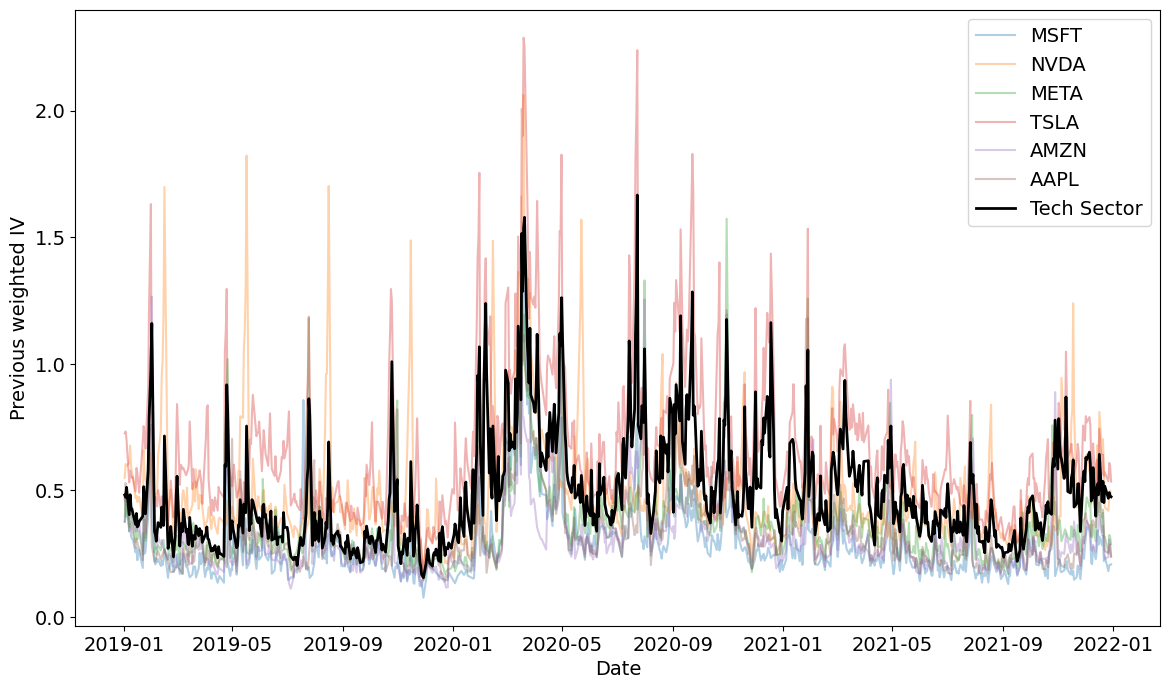

In [28]:
import matplotlib.pyplot as plt

# Ensure plots are displayed inline in the notebook
%matplotlib inline

# Plot previous_iv for each ticker in one graph
plt.figure(figsize=(14, 8))
for ticker in unique_tickers:
    ticker_data = df_all[df_all['Ticker'] == ticker]
    plt.plot(ticker_data['date'], ticker_data['previous_iv'], label=f'{ticker}', alpha = 0.35)

# Plot previous_iv_all for the tech sector
plt.plot(df_all['date'], df_all['previous_iv_all'], label='Tech Sector', linewidth=2, color ='black')

plt.xlabel('Date', fontsize=14)
plt.ylabel('Previous weighted IV', fontsize=14)
# plt.title('Previous weighted IV for each ticker and tech sector')
plt.legend()

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Set the legend with a larger font size
plt.legend(fontsize=14)


plt.savefig("previous_weighted_iv_tech_sector.pdf", format="pdf", bbox_inches="tight")

# Display the plot
plt.show()


In [352]:
# # Create a dictionary to hold DataFrames for each unique ticker
# df_s = {ticker: df for ticker, df in df_all.groupby('Ticker')}
# ticker_data = {f"{ticker}_data": df for ticker, df in df_s.items()}

In [353]:
# apple_data = (ticker_data['TSLA_data'])
# apple_data

In [354]:
import pandas as pd

# Assuming df is your original dataframe
df = df_all.copy()

# Filter the dataframe to only include rows where the Ticker is in the tech_sector list
tech_sector = ["MSFT", "AMZN", "NVDA", "META", "TSLA", "AAPL"]
df = df[df['Ticker'].isin(tech_sector)]

# Define the maturity (tau) ranges for short and long
bins = [-1, 5, float('inf')]  # Short <= 5 days, Long > 5 days
labels = ['Short', 'Long']
df['maturity_group'] = pd.cut(df['trading_days_till_exp'], bins=bins, labels=labels, right=True)

# Define the moneyness buckets and corresponding cp_flag restrictions
def classify_moneyness(moneyness, cp_flag):
    if 0.80 <= moneyness < 0.90 and cp_flag == 1:  # Calls only
        return '[0.80, 0.90]'
    elif 0.90 <= moneyness < 0.97 and cp_flag == 1:  # Calls only
        return '[0.90, 0.97]'
    elif 0.97 <= moneyness <= 1.03:  # Both calls and puts
        return '[0.97, 1.03]'
    elif 1.03 < moneyness <= 1.10 and cp_flag == 0:  # Puts only
        return '[1.03, 1.10]'
    elif 1.10 < moneyness <= 1.60 and cp_flag == 0:  # Puts only
        return '[1.10, 1.60]'
    else:
        return None  # Exclude anything not in these ranges

# Apply moneyness classification and filter out rows with null categories
df['m_category'] = df.apply(lambda row: classify_moneyness(row['moneyness'], row['cp_flag']), axis=1)
df = df[df['m_category'].notnull()]

# Ensure implied_volatility is in percentages if not already
df['impl_volatility'] = df['impl_volatility'] * 100  # Convert IV to %

# Group by maturity group and moneyness category, and calculate the required stats
summary = df.groupby(['maturity_group', 'm_category']).agg(
    Number=('date', 'count'),  # Count the number of options
    Mean_IV=('impl_volatility', 'mean'),  # Calculate the mean implied volatility per group
    Std_IV=('impl_volatility', 'std')  # Calculate the standard deviation of implied volatilities per group
).reset_index()

# Pivot the table to format it like your example
summary_pivot = summary.pivot(index='m_category', columns='maturity_group', values=['Number', 'Mean_IV', 'Std_IV'])

# Flatten the columns multi-index for better readability
summary_pivot.columns = ['_'.join(col).strip() for col in summary_pivot.columns.values]

# Reorder the columns to match the original table layout
summary_pivot = summary_pivot[['Number_Short', 'Mean_IV_Short', 'Std_IV_Short']]

# Rename columns to more readable format
summary_pivot.columns = ['Number (Short)', 'Mean IV (Short)', 'Std. dev. (Short)']

# Now calculate the total Mean IV and Std. dev. based on all individual observations, not just the group means
overall_mean_iv = df[df['maturity_group'] == 'Short']['impl_volatility'].mean()  # Overall mean IV for short maturity
overall_std_iv = df[df['maturity_group'] == 'Short']['impl_volatility'].std()  # Overall std dev for short maturity

# Calculate the total row based on all observations, not just grouped stats
total_row = pd.DataFrame({
    'Number (Short)': [summary_pivot['Number (Short)'].sum()],
    'Mean IV (Short)': [overall_mean_iv],  # Overall mean of all observations
    'Std. dev. (Short)': [overall_std_iv]   # Overall std dev of all observations
}, index=['Total'])

# Append the total row to the pivot table
summary_pivot = pd.concat([summary_pivot, total_row])


/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_1524/834297918.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby(['maturity_group', 'm_category']).agg(


In [355]:
summary_pivot

,Number (Short),Mean IV (Short),Std. dev. (Short)
"[0.80, 0.90]",24952.0,75.018337,30.298443
"[0.90, 0.97]",46534.0,48.430387,23.826537
"[0.97, 1.03]",104114.0,39.954967,23.260869
"[1.03, 1.10]",45635.0,51.514478,24.119740
"[1.10, 1.60]",52143.0,96.691314,46.041328
Total,273378.0,57.349264,36.688890


In [356]:
import pandas as pd

df = df_all.copy()

# Define the tech sector tickers
tech_sector = ["MSFT", "AMZN", "NVDA", "META", "TSLA", "AAPL"]

# Define the maturity (tau) ranges for short and long
bins = [-1, 5, float('inf')]  # Short <= 5 days, Long > 5 days
labels = ['Short', 'Long']

# Define the moneyness classification function
def classify_moneyness(moneyness, cp_flag):
    if 0.80 <= moneyness < 0.90 and cp_flag == 1:  # Calls only
        return '[0.80, 0.90]'
    elif 0.90 <= moneyness < 0.97 and cp_flag == 1:  # Calls only
        return '[0.90, 0.97]'
    elif 0.97 <= moneyness <= 1.03:  # Both calls and puts
        return '[0.97, 1.03]'
    elif 1.03 < moneyness <= 1.10 and cp_flag == 0:  # Puts only
        return '[1.03, 1.10]'
    elif 1.10 < moneyness <= 1.60 and cp_flag == 0:  # Puts only
        return '[1.10, 1.60]'
    else:
        return None  # Exclude anything not in these ranges

# Prepare an empty dictionary to store results for each ticker
summary_dict = {}

# Loop through each ticker and perform calculations separately
for ticker in tech_sector:
    ticker_df = df[df['Ticker'] == ticker].copy()  # Filter data for current ticker
    
    # Apply the maturity grouping
    ticker_df['maturity_group'] = pd.cut(ticker_df['trading_days_till_exp'], bins=bins, labels=labels, right=True)
    
    # Apply the moneyness classification
    ticker_df['m_category'] = ticker_df.apply(lambda row: classify_moneyness(row['moneyness'], row['cp_flag']), axis=1)
    
    # Filter out rows that don't fall into any moneyness category
    ticker_df = ticker_df[ticker_df['m_category'].notnull()]
    
    # Ensure implied_volatility is in percentages if not already
    ticker_df['impl_volatility'] = ticker_df['impl_volatility'] * 100  # Convert IV to %
    
    # Group by maturity group and moneyness category, and calculate the required stats
    summary = ticker_df.groupby(['maturity_group', 'm_category']).agg(
        Number=('date', 'count'),  # Count the number of options
        Mean_IV=('impl_volatility', 'mean'),  # Calculate the mean implied volatility
        Std_IV=('impl_volatility', 'std')  # Calculate the standard deviation of implied volatilities
    ).reset_index()
    
    # Pivot the table to format it like your example
    summary_pivot = summary.pivot(index='m_category', columns='maturity_group', values=['Number', 'Mean_IV', 'Std_IV'])
    
    # Flatten the columns multi-index for better readability
    summary_pivot.columns = ['_'.join(col).strip() for col in summary_pivot.columns.values]
    
    # Check if the necessary columns exist before proceeding
    for col in ['Number_Short', 'Mean_IV_Short', 'Std_IV_Short']:
        if col not in summary_pivot.columns:
            summary_pivot[col] = None  # Add missing columns as None if they don't exist
    
    # Reorder the columns to match the original table layout
    summary_pivot = summary_pivot[['Number_Short', 'Mean_IV_Short', 'Std_IV_Short']]
    
    # Rename columns to more readable format
    summary_pivot.columns = ['Number (Short)', 'Mean IV (Short)', 'Std. dev. (Short)']
    
    # Calculate the total row
    total_row = pd.DataFrame({
        'Number (Short)': [summary_pivot['Number (Short)'].sum()],
        'Mean IV (Short)': [summary_pivot['Mean IV (Short)'].mean()],  # Mean of the means
        'Std. dev. (Short)': [summary_pivot['Std. dev. (Short)'].mean()]  # Mean of standard deviations
    }, index=['Total'])
    
    # Append the total row to the pivot table
    summary_pivot = pd.concat([summary_pivot, total_row])
    
    # Store the result in the dictionary with the ticker name
    summary_dict[ticker] = summary_pivot

# Combine the individual summaries into one DataFrame for better visualization
combined_summary = pd.concat(summary_dict)

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_1524/1087493483.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = ticker_df.groupby(['maturity_group', 'm_category']).agg(
/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_1524/1087493483.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = ticker_df.groupby(['maturity_group', 'm_category']).agg(
/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_1524/1087493483.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to ret

In [357]:
combined_summary

Number (Short)  Mean IV (Short)  Std. dev. (Short)
MSFT [0.80, 0.90]           144.0        64.934856          18.097034
     [0.90, 0.97]          1188.0        38.696640          18.640031
     [0.97, 1.03]          7341.0        29.399451          15.817372
     [1.03, 1.10]          1926.0        43.115626          20.849805
     [1.10, 1.60]           720.0        84.012151          37.055422
     Total                11319.0        52.031745          22.091933
AMZN [0.80, 0.90]         14559.0        66.421130          23.709249
     [0.90, 0.97]         27860.0        41.716471          17.624647
     [0.97, 1.03]         54238.0        32.691536          16.314359
     [1.03, 1.10]         25358.0        43.707718          16.151597
     [1.10, 1.60]         24590.0        75.737127          31.246798
     Total               146605.0        52.054797          21.009330
NVDA [0.80, 0.90]          2093.0        69.849978          25.737577
     [0.90, 0.97]          4862.0        52.171399          19.681758
     [0.97, 1.03]         11307.0        48.430707          19.794700
     [1.03, 1.10]          5298.0        56.874377          21.229351
     [1.10, 1.60]          5135.0        86.992547          39.102128
     Total                28695.0        62.863802          25.109103
META [0.80, 0.90]           545.0        67.561486          23.401512
     [0.90, 0.97]          2421.0        44.020354          19.542796
     [0.97, 1.03]          7884.0        38.453266          18.350782
     [1.03, 1.10]          2910.0        48.567474          20.311793
     [1.10, 1.60]          1490.0        77.986830          33.746700
     Total                15250.0        55.317882          23.070716
TSLA [0.80, 0.90]          7223.0        95.088517          34.721287
     [0.90, 0.97]          8293.0        72.831806          29.906541
     [0.97, 1.03]         15029.0        68.525331          30.372901
     [1.03, 1.10]          7533.0        79.291820          30.410948
     [1.10, 1.60]         19048.0       129.794582          46.689030
     Total                57126.0        89.106411          34.420141
AAPL [0.80, 0.90]           388.0        66.083333          20.765319
     [0.90, 0.97]          1910.0        42.535253          18.300195
     [0.97, 1.03]          8315.0        34.911340          15.981309
     [1.03, 1.10]          2610.0        45.795067          17.363504
     [1.10, 1.60]          1160.0        72.134624          29.086947
     Total                14383.0        52.291923          20.299455

In [358]:
import numpy as np

# Function to ensure scalar values
def ensure_scalar(value):
    if isinstance(value, np.ndarray):
        if value.size == 1:  # Single-element array
            return value.item()
        else:  # Multi-element array, decide on a fallback
            return np.nan  # Replace with NaN
    return value  # Already a scalar

# Clean up the columns
columns_to_clean = ['impl_volatility_h_1_step', 'impl_volatility_h_5_step']

for column in columns_to_clean:
    df_all[column] = df_all[column].apply(ensure_scalar)

# Verify the result for both columns
for column in columns_to_clean:
    print(f"{column}:")
    print(df_all[column].apply(type).value_counts())

impl_volatility_h_1_step:
impl_volatility_h_1_step
<class 'float'>    273378
Name: count, dtype: int64
impl_volatility_h_5_step:
impl_volatility_h_5_step
<class 'float'>    273378
Name: count, dtype: int64


/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_1524/3226976196.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all[column] = df_all[column].apply(ensure_scalar)


In [387]:
# Count the number of rows for each ticker
ticker_counts = df_all['Ticker'].value_counts()

# Display the counts
print(ticker_counts)

# If you want to reset the index and display it as a DataFrame
ticker_counts_df = ticker_counts.reset_index()
ticker_counts_df.columns = ['Ticker', 'Row Count']
print(ticker_counts_df)


Ticker
AMZN    146605
TSLA     57126
NVDA     28695
META     15250
AAPL     14383
MSFT     11319
Name: count, dtype: int64
  Ticker  Row Count
0   AMZN     146605
1   TSLA      57126
2   NVDA      28695
3   META      15250
4   AAPL      14383
5   MSFT      11319


# Standardizing all the data

In [359]:
#Restrictions
timeperiod = [datetime.datetime(2018, 12, 30), datetime.datetime(2021, 12, 31)]
train_period = [datetime.datetime(2019, 1, 1), datetime.datetime(2020, 12, 31)]
trainperiod1 = [datetime.datetime(2019, 1, 1), datetime.datetime(2019, 12, 31)]
trainperiod2 = [datetime.datetime(2020, 1, 1), datetime.datetime(2020, 12, 31)]

options_total = df_all

option_train = options_total[(options_total["date"] >= train_period[0]) & (options_total["date"] <= train_period[1])]
option_train1 = options_total[(options_total["date"] >= trainperiod1[0]) & (options_total["date"] <= trainperiod1[1])]
option_train2 = options_total[(options_total["date"] >= trainperiod2[0]) & (options_total["date"] <= trainperiod2[1])]

option_test = options_total[(options_total["date"] > train_period[1])]

In [360]:
option_train

,date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,...,ticker_MSFT,ticker_NVDA,ticker_TSLA,Ticker,impl_volatility_h_1_step,impl_volatility_h_5_step,dollar_volume,total_iv_weighted,previous_iv,previous_iv_all
421,2019-01-02,1,1697500,0.07,0.34,10,9,0.559793,0.009631,0.000405,...,0,0,0,AMZN,1.445527,0.643147,2.050,1.147576,0.464022,0.481550
422,2019-01-02,1,1667500,0.27,0.45,22,56,0.507672,0.017431,0.000745,...,0,0,0,AMZN,1.204495,0.546600,7.920,4.020762,0.464022,0.481550
423,2019-01-02,1,1670000,0.36,0.44,32,202,0.523699,0.018633,0.000765,...,0,0,0,AMZN,1.224912,0.552881,12.800,6.703347,0.464022,0.481550
424,2019-01-02,1,1672500,0.09,0.45,11,51,0.503224,0.013573,0.000607,...,0,0,0,AMZN,1.245268,0.559628,2.970,1.494575,0.464022,0.481550
425,2019-01-02,1,1500000,44.00,46.45,3189,1574,0.436638,0.792958,0.005744,...,0,0,0,AMZN,0.530190,0.399060,144222.525,62973.034871,0.464022,0.481550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173367,2020-12-31,0,3340000,101.05,103.60,108,108,0.258224,-0.738607,0.002613,...,0,0,0,AMZN,0.356984,0.265274,11051.100,2853.659246,0.219433,0.416969
173368,2020-12-31,0,3335000,97.45,99.90,10,40,0.258676,-0.725328,0.002674,...,0,0,0,AMZN,0.355609,0.265490,986.750,255.248543,0.219433,0.416969
173369,2020-12-31,0,3330000,93.45,95.85,35,109,0.256440,-0.713888,0.002751,...,0,0,0,AMZN,0.355770,0.265789,3312.750,849.521610,0.219433,0.416969
173370,2020-12-31,0,3325000,90.00,92.20,29,316,0.256743,-0.700050,0.002809,...,0,0,0,AMZN,0.353283,0.266182,2641.900,678.289332,0.219433,0.416969


# Total datasave for train / test


In [361]:
# Save the parquet file
data_set_train_nonscaled_new = "/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_train_tech_nonscaled.parquet"

save_parquet = True
if save_parquet or not os.path.exists(data_set_train_nonscaled_new):
    option_train.to_parquet(data_set_train_nonscaled_new)

In [362]:
data_set_test_nonscaled_new = "/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_test_tech_nonscaled.parquet"

save_parquet = True
if save_parquet or not os.path.exists(data_set_test_nonscaled_new):
    option_test.to_parquet(data_set_test_nonscaled_new)

# Standardized data train


In [363]:
option_train

,date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,...,ticker_MSFT,ticker_NVDA,ticker_TSLA,Ticker,impl_volatility_h_1_step,impl_volatility_h_5_step,dollar_volume,total_iv_weighted,previous_iv,previous_iv_all
421,2019-01-02,1,1697500,0.07,0.34,10,9,0.559793,0.009631,0.000405,...,0,0,0,AMZN,1.445527,0.643147,2.050,1.147576,0.464022,0.481550
422,2019-01-02,1,1667500,0.27,0.45,22,56,0.507672,0.017431,0.000745,...,0,0,0,AMZN,1.204495,0.546600,7.920,4.020762,0.464022,0.481550
423,2019-01-02,1,1670000,0.36,0.44,32,202,0.523699,0.018633,0.000765,...,0,0,0,AMZN,1.224912,0.552881,12.800,6.703347,0.464022,0.481550
424,2019-01-02,1,1672500,0.09,0.45,11,51,0.503224,0.013573,0.000607,...,0,0,0,AMZN,1.245268,0.559628,2.970,1.494575,0.464022,0.481550
425,2019-01-02,1,1500000,44.00,46.45,3189,1574,0.436638,0.792958,0.005744,...,0,0,0,AMZN,0.530190,0.399060,144222.525,62973.034871,0.464022,0.481550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173367,2020-12-31,0,3340000,101.05,103.60,108,108,0.258224,-0.738607,0.002613,...,0,0,0,AMZN,0.356984,0.265274,11051.100,2853.659246,0.219433,0.416969
173368,2020-12-31,0,3335000,97.45,99.90,10,40,0.258676,-0.725328,0.002674,...,0,0,0,AMZN,0.355609,0.265490,986.750,255.248543,0.219433,0.416969
173369,2020-12-31,0,3330000,93.45,95.85,35,109,0.256440,-0.713888,0.002751,...,0,0,0,AMZN,0.355770,0.265789,3312.750,849.521610,0.219433,0.416969
173370,2020-12-31,0,3325000,90.00,92.20,29,316,0.256743,-0.700050,0.002809,...,0,0,0,AMZN,0.353283,0.266182,2641.900,678.289332,0.219433,0.416969


# Standardized data with bid filter

In [364]:
option_train_filter = option_train[option_train['prc_option'] >= 0.125]

from sklearn.preprocessing import StandardScaler

def standardize_columns(df, exclude_columns):
    
    # Select columns to standardize
    columns_to_standardize = [col for col in df.columns if col not in exclude_columns]

    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Apply the scaler to the selected columns
    df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])

    return df

# Columns to exclude from standardization
exclude_columns = collumns_exclude

# Apply the function to the dataframe
df_train_standardiz_filter = standardize_columns(option_train_filter, exclude_columns)

# Display the standardized dataframe
df_train_standardiz_filter

,date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,...,ticker_MSFT,ticker_NVDA,ticker_TSLA,Ticker,impl_volatility_h_1_step,impl_volatility_h_5_step,dollar_volume,total_iv_weighted,previous_iv,previous_iv_all
421,2019-01-02,1,0.224218,-0.470324,-0.468200,-0.329434,-0.384042,0.559793,0.012080,-0.478085,...,0,0,0,AMZN,1.445527,0.643147,-0.238959,-0.175597,-0.056179,-0.283184
422,2019-01-02,1,0.195566,-0.461663,-0.463541,-0.327707,-0.372108,0.507672,0.033609,-0.462784,...,0,0,0,AMZN,1.204495,0.546600,-0.238859,-0.175542,-0.056179,-0.283184
423,2019-01-02,1,0.197954,-0.457766,-0.463964,-0.326269,-0.335037,0.523699,0.036926,-0.461884,...,0,0,0,AMZN,1.224912,0.552881,-0.238776,-0.175491,-0.056179,-0.283184
424,2019-01-02,1,0.200342,-0.469458,-0.463541,-0.329290,-0.373378,0.503224,0.022960,-0.468995,...,0,0,0,AMZN,1.245268,0.559628,-0.238943,-0.175590,-0.056179,-0.283184
425,2019-01-02,1,0.035593,1.431971,1.484853,0.127964,0.013337,0.436638,2.174139,-0.237812,...,0,0,0,AMZN,0.530190,0.399060,2.214955,1.025472,-0.056179,-0.283184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173367,2020-12-31,0,1.792907,3.902399,3.905520,-0.315334,-0.358905,0.258224,-2.053130,-0.378718,...,0,0,0,AMZN,0.356984,0.265274,-0.050959,-0.121191,-0.860331,-0.524777
173368,2020-12-31,0,1.788132,3.746509,3.748802,-0.329434,-0.376171,0.258676,-2.016479,-0.375973,...,0,0,0,AMZN,0.355609,0.265490,-0.222204,-0.170750,-0.860331,-0.524777
173369,2020-12-31,0,1.783356,3.573298,3.577258,-0.325837,-0.358651,0.256440,-1.984904,-0.372507,...,0,0,0,AMZN,0.355770,0.265789,-0.182627,-0.159416,-0.860331,-0.524777
173370,2020-12-31,0,1.778581,3.423903,3.422658,-0.326700,-0.306090,0.256743,-1.946709,-0.369897,...,0,0,0,AMZN,0.353283,0.266182,-0.194042,-0.162682,-0.860331,-0.524777


In [365]:
from sklearn.preprocessing import StandardScaler

def standardize_columns(df, exclude_columns):
    
    # Select columns to standardize
    columns_to_standardize = [col for col in df.columns if col not in exclude_columns]

    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Apply the scaler to the selected columns
    df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])

    return df

# Columns to exclude from standardization
exclude_columns = collumns_exclude

# Apply the function to the dataframe
df_train_standardiz = standardize_columns(option_train, exclude_columns)

# Display the standardized dataframe
df_train_standardiz

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_1524/2778359298.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])


,date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,...,ticker_MSFT,ticker_NVDA,ticker_TSLA,Ticker,impl_volatility_h_1_step,impl_volatility_h_5_step,dollar_volume,total_iv_weighted,previous_iv,previous_iv_all
421,2019-01-02,1,0.224218,-0.470324,-0.468200,-0.329434,-0.384042,0.559793,0.012080,-0.478085,...,0,0,0,AMZN,1.445527,0.643147,-0.238959,-0.175597,-0.056179,-0.283184
422,2019-01-02,1,0.195566,-0.461663,-0.463541,-0.327707,-0.372108,0.507672,0.033609,-0.462784,...,0,0,0,AMZN,1.204495,0.546600,-0.238859,-0.175542,-0.056179,-0.283184
423,2019-01-02,1,0.197954,-0.457766,-0.463964,-0.326269,-0.335037,0.523699,0.036926,-0.461884,...,0,0,0,AMZN,1.224912,0.552881,-0.238776,-0.175491,-0.056179,-0.283184
424,2019-01-02,1,0.200342,-0.469458,-0.463541,-0.329290,-0.373378,0.503224,0.022960,-0.468995,...,0,0,0,AMZN,1.245268,0.559628,-0.238943,-0.175590,-0.056179,-0.283184
425,2019-01-02,1,0.035593,1.431971,1.484853,0.127964,0.013337,0.436638,2.174139,-0.237812,...,0,0,0,AMZN,0.530190,0.399060,2.214955,1.025472,-0.056179,-0.283184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173367,2020-12-31,0,1.792907,3.902399,3.905520,-0.315334,-0.358905,0.258224,-2.053130,-0.378718,...,0,0,0,AMZN,0.356984,0.265274,-0.050959,-0.121191,-0.860331,-0.524777
173368,2020-12-31,0,1.788132,3.746509,3.748802,-0.329434,-0.376171,0.258676,-2.016479,-0.375973,...,0,0,0,AMZN,0.355609,0.265490,-0.222204,-0.170750,-0.860331,-0.524777
173369,2020-12-31,0,1.783356,3.573298,3.577258,-0.325837,-0.358651,0.256440,-1.984904,-0.372507,...,0,0,0,AMZN,0.355770,0.265789,-0.182627,-0.159416,-0.860331,-0.524777
173370,2020-12-31,0,1.778581,3.423903,3.422658,-0.326700,-0.306090,0.256743,-1.946709,-0.369897,...,0,0,0,AMZN,0.353283,0.266182,-0.194042,-0.162682,-0.860331,-0.524777


In [366]:
mean_values = df_train_standardiz_filter.drop(columns=['date', 'Ticker']).mean()
std_values = df_train_standardiz_filter.drop(columns=['date', 'Ticker']).std()
print("Mean values:")
print(mean_values)
print("\nStandard Deviation values:")
print(std_values)
print("\n" + "-"*50 + "\n")

Mean values:
cp_flag                         4.504166e-01
strike_price                   -4.338415e-17
best_bid                       -1.608418e-16
best_offer                     -4.219272e-17
volume                          0.000000e+00
open_interest                  -4.930016e-19
impl_volatility                 5.971458e-01
delta                           1.602255e-17
gamma                          -4.486315e-17
vega                           -6.573355e-18
theta                          -1.248938e-16
prc_option                      7.222474e-17
trading_days_till_exp           3.023743e-17
PRC                            -9.761433e-17
PRC_actual                     -3.575905e-16
Year                            1.987060e-13
Annual_Dividend_Yield           4.979317e-17
T                              -3.602199e-16
2Y_bond                        -2.313821e-16
Forward_Price                  -9.367031e-17
moneyness                       1.104077e-15
trading_day                     9.465632e-

In [367]:
from sklearn.preprocessing import MinMaxScaler

def min_max_scale_columns(df, exclude_columns):
    # Select columns to scale
    columns_to_scale = [col for col in df.columns if col not in exclude_columns]

    # Initialize the MinMaxScaler
    scaler = MinMaxScaler(feature_range=(-1, 1))

    # Apply the scaler to the selected columns
    df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

    return df

# Columns to exclude from scaling
exclude_columns = collumns_exclude

# Apply the function to the dataframe
df_train_stan = min_max_scale_columns(option_train, exclude_columns)

# Display the scaled dataframe
df_train_stan


/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_1524/238488245.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])


,date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,...,ticker_MSFT,ticker_NVDA,ticker_TSLA,Ticker,impl_volatility_h_1_step,impl_volatility_h_5_step,dollar_volume,total_iv_weighted,previous_iv,previous_iv_all
421,2019-01-02,1,-0.243117,-0.999564,-0.998720,-0.999948,-0.999904,0.559793,0.009695,-0.998321,...,0,0,0,AMZN,1.445527,0.643147,-0.999999,-1.000000,-0.649110,-0.568026
422,2019-01-02,1,-0.257176,-0.998320,-0.998049,-0.999878,-0.999402,0.507672,0.017497,-0.996887,...,0,0,0,AMZN,1.204495,0.546600,-0.999996,-0.999998,-0.649110,-0.568026
423,2019-01-02,1,-0.256005,-0.997759,-0.998110,-0.999820,-0.997842,0.523699,0.018699,-0.996803,...,0,0,0,AMZN,1.224912,0.552881,-0.999994,-0.999997,-0.649110,-0.568026
424,2019-01-02,1,-0.254833,-0.999440,-0.998049,-0.999942,-0.999455,0.503224,0.013638,-0.997469,...,0,0,0,AMZN,1.245268,0.559628,-0.999999,-0.999999,-0.649110,-0.568026
425,2019-01-02,1,-0.335677,-0.726155,-0.717664,-0.981476,-0.983186,0.436638,0.793142,-0.975800,...,0,0,0,AMZN,0.530190,0.399060,-0.935241,-0.972375,-0.649110,-0.568026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173367,2020-12-31,0,0.526655,-0.371091,-0.369316,-0.999378,-0.998846,0.258224,-0.738657,-0.989007,...,0,0,0,AMZN,0.356984,0.265274,-0.995038,-0.998748,-0.870264,-0.653477
173368,2020-12-31,0,0.524312,-0.393496,-0.391869,-0.999948,-0.999573,0.258676,-0.725376,-0.988750,...,0,0,0,AMZN,0.355609,0.265490,-0.999557,-0.999888,-0.870264,-0.653477
173369,2020-12-31,0,0.521968,-0.418391,-0.416555,-0.999802,-0.998836,0.256440,-0.713934,-0.988425,...,0,0,0,AMZN,0.355770,0.265789,-0.998513,-0.999627,-0.870264,-0.653477
173370,2020-12-31,0,0.519625,-0.439863,-0.438803,-0.999837,-0.996624,0.256743,-0.700094,-0.988180,...,0,0,0,AMZN,0.353283,0.266182,-0.998814,-0.999702,-0.870264,-0.653477


In [368]:
#Minmax

data_set_standardized_tot = "/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_train_val_tech_scaled.parquet"

save_parquet = True
if save_parquet or not os.path.exists(data_set_standardized_tot):
    df_train_stan.to_parquet(data_set_standardized_tot)

#Standardize

data_set_standardized_tot_train = "/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_train_val_tech_standardized.parquet"

save_parquet = True
if save_parquet or not os.path.exists(data_set_standardized_tot_train):
    df_train_standardiz.to_parquet(data_set_standardized_tot_train)

#Standardize filter
data_set_standardized_tot_train_filter = "/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_train_val_tech_standardized_filter.parquet"
if save_parquet or not os.path.exists(data_set_standardized_tot_train_filter):
    df_train_standardiz_filter.to_parquet(data_set_standardized_tot_train_filter)


# Standardized data test

In [369]:
from sklearn.preprocessing import StandardScaler
data_set_train_nonscaled_new = "/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_train_tech_nonscaled.parquet"
data_set_test_nonscaled_new = "/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_test_tech_nonscaled.parquet"
data_set_train_nonscaled_new = pd.read_parquet(data_set_train_nonscaled_new)
data_set_test_nonscaled_new = pd.read_parquet(data_set_test_nonscaled_new)

def standardize_columns(df, exclude_columns, scaler=None):
    # Select columns to standardize
    columns_to_standardize = [col for col in df.columns if col not in exclude_columns]

    # Initialize the StandardScaler if not provided
    if scaler is None:
        scaler = StandardScaler()
        df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])
    else:
        df[columns_to_standardize] = scaler.transform(df[columns_to_standardize])

    return df, scaler

# Columns to exclude from standardization
exclude_columns = collumns_exclude

# Standardize the training data
df_all_standardized_sso_train, scaler = standardize_columns(data_set_train_nonscaled_new, exclude_columns)

# Standardize the test data for each ticker using the corresponding scaler
df_all_standardized_sso_test_all_sso = data_set_test_nonscaled_new.groupby('Ticker').apply(
    lambda group: standardize_columns(group, exclude_columns, scaler)[0]
).reset_index(drop=True)

# Display the standardized test dataframe
df_all_standardized_sso_test_all_sso


/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_1524/2373183746.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_all_standardized_sso_test_all_sso = data_set_test_nonscaled_new.groupby('Ticker').apply(


,date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,...,ticker_MSFT,ticker_NVDA,ticker_TSLA,Ticker,impl_volatility_h_1_step,impl_volatility_h_5_step,dollar_volume,total_iv_weighted,previous_iv,previous_iv_all
0,2021-01-04,0,-1.275706,-0.410566,-0.420337,2.193667,1.785927,0.463496,-0.953739,2.129904,...,0,0,0,AAPL,0.493447,0.416914,0.196883,0.050845,-0.516830,-0.241027
1,2021-01-04,0,-1.274751,-0.394977,-0.405089,2.086763,0.961715,0.457994,-1.119395,2.305777,...,0,0,0,AAPL,0.474071,0.414822,0.281350,0.091521,-0.516830,-0.241027
2,2021-01-04,0,-1.273796,-0.376357,-0.386876,2.537831,1.380169,0.454101,-1.294818,2.409330,...,0,0,0,AAPL,0.457912,0.413991,0.524308,0.212923,-0.516830,-0.241027
3,2021-01-04,0,-1.272841,-0.355138,-0.365697,3.745713,2.696726,0.450365,-1.474520,2.437862,...,0,0,0,AAPL,0.445151,0.413657,1.084334,0.492449,-0.516830,-0.241027
4,2021-01-04,0,-1.271886,-0.332621,-0.340707,1.386349,0.730651,0.445678,-1.654263,2.393624,...,0,0,0,AAPL,0.433588,0.413453,0.431151,0.159176,-0.516830,-0.241027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100422,2021-12-30,0,-0.461039,-0.453436,-0.462270,0.272565,0.635686,0.870581,-0.083707,-0.442218,...,0,0,1,TSLA,0.610330,1.069063,-0.205454,-0.142888,0.176331,-0.310054
100423,2021-12-30,0,-0.546994,-0.468592,-0.476248,-0.276342,0.488922,1.393724,-0.028665,-0.487761,...,0,0,1,TSLA,0.694156,1.551327,-0.238155,-0.174309,0.176331,-0.310054
100424,2021-12-30,1,-0.265251,-0.466427,-0.474553,-0.072606,0.032888,0.840809,0.015814,-0.468635,...,0,0,1,TSLA,0.645521,0.819447,-0.233649,-0.170581,0.176331,-0.310054
100425,2021-12-30,1,-0.255700,-0.467726,-0.474977,-0.151453,-0.056490,0.887061,0.011401,-0.473450,...,0,0,1,TSLA,0.653035,0.864253,-0.235705,-0.172349,0.176331,-0.310054


# For the filter of the bidprice data

In [370]:
data_set_train_nonscaled_new = "/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_train_tech_nonscaled.parquet"
data_set_test_nonscaled_new = "/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_test_tech_nonscaled.parquet"
data_set_train_nonscaled_new = pd.read_parquet(data_set_train_nonscaled_new)
data_set_test_nonscaled_new = pd.read_parquet(data_set_test_nonscaled_new)

data_set_train_nonscaled_new_filer = data_set_train_nonscaled_new[data_set_train_nonscaled_new['prc_option'] >= 0.125]
data_set_test_nonscaled_new_filer = data_set_test_nonscaled_new[data_set_test_nonscaled_new['prc_option'] >= 0.125]


def standardize_columns(df, exclude_columns, scaler=None):
    # Select columns to standardize
    columns_to_standardize = [col for col in df.columns if col not in exclude_columns]

    # Initialize the StandardScaler if not provided
    if scaler is None:
        scaler = StandardScaler()
        df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])
    else:
        df[columns_to_standardize] = scaler.transform(df[columns_to_standardize])

    return df, scaler

# Columns to exclude from standardization
exclude_columns = collumns_exclude

# Standardize the training data
df_all_standardized_sso_train, scaler = standardize_columns(data_set_train_nonscaled_new_filer, exclude_columns)

# Standardize the test data for each ticker using the corresponding scaler
df_all_standardized_sso_test_all_sso_filter = data_set_test_nonscaled_new_filer.groupby('Ticker').apply(
    lambda group: standardize_columns(group, exclude_columns, scaler)[0]
).reset_index(drop=True)

# Display the standardized test dataframe
df_all_standardized_sso_test_all_sso_filter


/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_1524/2442144524.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_all_standardized_sso_test_all_sso_filter = data_set_test_nonscaled_new_filer.groupby('Ticker').apply(


,date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,...,ticker_MSFT,ticker_NVDA,ticker_TSLA,Ticker,impl_volatility_h_1_step,impl_volatility_h_5_step,dollar_volume,total_iv_weighted,previous_iv,previous_iv_all
0,2021-01-04,0,-1.275706,-0.410566,-0.420337,2.193667,1.785927,0.463496,-0.953739,2.129904,...,0,0,0,AAPL,0.493447,0.416914,0.196883,0.050845,-0.516830,-0.241027
1,2021-01-04,0,-1.274751,-0.394977,-0.405089,2.086763,0.961715,0.457994,-1.119395,2.305777,...,0,0,0,AAPL,0.474071,0.414822,0.281350,0.091521,-0.516830,-0.241027
2,2021-01-04,0,-1.273796,-0.376357,-0.386876,2.537831,1.380169,0.454101,-1.294818,2.409330,...,0,0,0,AAPL,0.457912,0.413991,0.524308,0.212923,-0.516830,-0.241027
3,2021-01-04,0,-1.272841,-0.355138,-0.365697,3.745713,2.696726,0.450365,-1.474520,2.437862,...,0,0,0,AAPL,0.445151,0.413657,1.084334,0.492449,-0.516830,-0.241027
4,2021-01-04,0,-1.271886,-0.332621,-0.340707,1.386349,0.730651,0.445678,-1.654263,2.393624,...,0,0,0,AAPL,0.433588,0.413453,0.431151,0.159176,-0.516830,-0.241027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100422,2021-12-30,0,-0.461039,-0.453436,-0.462270,0.272565,0.635686,0.870581,-0.083707,-0.442218,...,0,0,1,TSLA,0.610330,1.069063,-0.205454,-0.142888,0.176331,-0.310054
100423,2021-12-30,0,-0.546994,-0.468592,-0.476248,-0.276342,0.488922,1.393724,-0.028665,-0.487761,...,0,0,1,TSLA,0.694156,1.551327,-0.238155,-0.174309,0.176331,-0.310054
100424,2021-12-30,1,-0.265251,-0.466427,-0.474553,-0.072606,0.032888,0.840809,0.015814,-0.468635,...,0,0,1,TSLA,0.645521,0.819447,-0.233649,-0.170581,0.176331,-0.310054
100425,2021-12-30,1,-0.255700,-0.467726,-0.474977,-0.151453,-0.056490,0.887061,0.011401,-0.473450,...,0,0,1,TSLA,0.653035,0.864253,-0.235705,-0.172349,0.176331,-0.310054


In [371]:
data_set_test_total_new_all_sso_filter = "/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_test_tech_scaled_all_sso_filter.parquet"

save_parquet = True
if save_parquet or not os.path.exists(data_set_test_total_new_all_sso_filter):
    df_all_standardized_sso_test_all_sso_filter.to_parquet(data_set_test_total_new_all_sso_filter)

In [372]:
data_set_test_total_new_all_sso = "/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_test_tech_scaled_all_sso.parquet"

save_parquet = True
if save_parquet or not os.path.exists(data_set_test_total_new_all_sso):
    df_all_standardized_sso_test_all_sso.to_parquet(data_set_test_total_new_all_sso)

In [373]:
for ticker in unique_tickers:
    ticker_data = df_all_standardized_sso_train
    mean_values = ticker_data.drop(columns=['date', 'Ticker']).mean()
    std_values = ticker_data.drop(columns=['date', 'Ticker']).std()
    print(f"Ticker: {ticker}")
    print("Mean values:")
    print(mean_values)
    print("\nStandard Deviation values:")
    print(std_values)
    print("\n" + "-"*50 + "\n")


Ticker: MSFT
Mean values:
cp_flag                         4.504166e-01
strike_price                   -4.338415e-17
best_bid                       -1.608418e-16
best_offer                     -4.219272e-17
volume                          0.000000e+00
open_interest                  -4.930016e-19
impl_volatility                 5.971458e-01
delta                           1.602255e-17
gamma                          -4.486315e-17
vega                           -6.573355e-18
theta                          -1.248938e-16
prc_option                      7.222474e-17
trading_days_till_exp           3.023743e-17
PRC                            -9.761433e-17
PRC_actual                     -3.575905e-16
Year                            1.987060e-13
Annual_Dividend_Yield           4.979317e-17
T                              -3.602199e-16
2Y_bond                        -2.313821e-16
Forward_Price                  -9.367031e-17
moneyness                       1.104077e-15
trading_day                  

In [374]:
data_set_train_nonscaled_new = "/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_train_tech_nonscaled.parquet"
data_set_test_nonscaled_new = "/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_test_tech_nonscaled.parquet"
data_set_train_nonscaled_new = pd.read_parquet(data_set_train_nonscaled_new)
data_set_test_nonscaled_new = pd.read_parquet(data_set_test_nonscaled_new)


# from sklearn.preprocessing import StandardScaler

# def standardize_test_data(option_train, option_test, exclude_columns):
#     # Initialize the StandardScaler
#     scaler = StandardScaler()

#     # Fit the scaler on the training data (excluding the columns that should not be standardized)
#     scaler.fit(option_train.drop(columns=exclude_columns))

#     # Apply the scaler to the test data (excluding the columns that should not be standardized)
#     option_test_standardized = option_test.copy()
#     columns_to_standardize = [col for col in option_test.columns if col not in exclude_columns]
#     option_test_standardized[columns_to_standardize] = scaler.transform(option_test[columns_to_standardize])

#     return option_test_standardized

# # Usage
# exclude_columns = collumns_exclude
# option_test_standardized = standardize_test_data(data_set_train_nonscaled_new, data_set_test_nonscaled_new, exclude_columns)

# # Display the standardized test dataframe
# option_test_standardized

In [375]:
def min_max_scale_test_data(option_train, option_test, exclude_columns):
    # Initialize the MinMaxScaler with feature range (-1, 1)
    scaler = MinMaxScaler(feature_range=(-1, 1))

    # Fit the scaler on the training data (excluding the columns that should not be scaled)
    scaler.fit(option_train.drop(columns=exclude_columns))

    # Apply the scaler to the test data (excluding the columns that should not be scaled)
    option_test_scaled = option_test.copy()
    columns_to_scale = [col for col in option_test.columns if col not in exclude_columns]
    option_test_scaled[columns_to_scale] = scaler.transform(option_test[columns_to_scale])

    return option_test_scaled

# Usage
exclude_columns = collumns_exclude
option_test_scaled = min_max_scale_test_data(data_set_train_nonscaled_new, data_set_test_nonscaled_new, exclude_columns)

# Display the scaled test dataframe
option_test_scaled

,date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,...,ticker_MSFT,ticker_NVDA,ticker_TSLA,Ticker,impl_volatility_h_1_step,impl_volatility_h_5_step,dollar_volume,total_iv_weighted,previous_iv,previous_iv_all
173372,2021-01-04,0,-0.979145,-0.990976,-0.991832,-0.898053,-0.908610,0.463496,-0.340280,-0.753867,...,0,0,0,AAPL,0.493447,0.416914,-0.988497,-0.994791,-0.775796,-0.553115
173373,2021-01-04,0,-0.978676,-0.988735,-0.989638,-0.902371,-0.943286,0.457994,-0.400307,-0.737382,...,0,0,0,AAPL,0.474071,0.414822,-0.986268,-0.993856,-0.775796,-0.553115
173374,2021-01-04,0,-0.978207,-0.986059,-0.987017,-0.884155,-0.925681,0.454101,-0.463874,-0.727676,...,0,0,0,AAPL,0.457912,0.413991,-0.979857,-0.991064,-0.775796,-0.553115
173375,2021-01-04,0,-0.977739,-0.983009,-0.983969,-0.835375,-0.870292,0.450365,-0.528991,-0.725001,...,0,0,0,AAPL,0.445151,0.413657,-0.965078,-0.984634,-0.775796,-0.553115
173376,2021-01-04,0,-0.977270,-0.979773,-0.980373,-0.930657,-0.953007,0.445678,-0.594123,-0.729148,...,0,0,0,AAPL,0.433588,0.413453,-0.982315,-0.992300,-0.775796,-0.553115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273794,2021-12-30,0,0.580551,-0.504901,-0.476594,-0.999134,-0.998590,0.258606,-0.961955,-0.992302,...,0,0,0,AMZN,0.232330,0.199780,-0.994425,-0.998591,-0.851379,-0.577529
273795,2021-12-30,0,0.582894,-0.473782,-0.446117,-0.999924,-0.997415,0.271209,-0.963504,-0.992909,...,0,0,0,AMZN,0.233141,0.181504,-0.999448,-0.999854,-0.851379,-0.577529
273796,2021-12-30,0,0.585237,-0.443597,-0.415641,-0.999617,-0.998536,0.278041,-0.967729,-0.993740,...,0,0,0,AMZN,0.233369,0.163282,-0.997211,-0.999242,-0.851379,-0.577529
273797,2021-12-30,0,0.589924,-0.381982,-0.355602,-0.999768,-0.998622,0.291246,-0.974678,-0.995107,...,0,0,0,AMZN,0.234573,0.126994,-0.998112,-0.999463,-0.851379,-0.577529


In [376]:
# data_set_test_total_new = "/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_test_tech_scaled.parquet"

# save_parquet = True
# if save_parquet or not os.path.exists(data_set_test_total_new):
#     option_test_standardized.to_parquet(data_set_test_total_new)

# Standardize for each firm specfic


In [377]:
from sklearn.preprocessing import StandardScaler

data_set_train_nonscaled_new = "/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_train_tech_nonscaled.parquet"
data_set_test_nonscaled_new = "/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_test_tech_nonscaled.parquet"
df_all_train = pd.read_parquet(data_set_train_nonscaled_new)
df_all_test = pd.read_parquet(data_set_test_nonscaled_new)



# Define the function to standardize columns
def standardize_columns(df, exclude_columns, scaler=None):
    # Select columns to standardize
    columns_to_standardize = [col for col in df.columns if col not in exclude_columns]

    # Initialize the StandardScaler if not provided
    if scaler is None:
        scaler = StandardScaler()
        df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])
    else:
        df[columns_to_standardize] = scaler.transform(df[columns_to_standardize])

    return df, scaler

# Columns to exclude from standardization
exclude_columns = collumns_exclude

columns_to_standardize = [col for col in df_all_train.columns if col not in exclude_columns]

# Initialize and fit the scaler on the entire training dataset
scaler = StandardScaler()
df_all_train[columns_to_standardize] = scaler.fit_transform(df_all_train[columns_to_standardize])

# Function to standardize using the pre-fitted scaler
def apply_scaler_to_group(df, columns, scaler):
    df[columns] = scaler.transform(df[columns])
    return df

# Apply the scaler to each ticker group in the test dataset
df_all_standardized_sso_test_ticker = df_all_test.groupby('Ticker', group_keys=False).apply(
    lambda group: apply_scaler_to_group(group, columns_to_standardize, scaler)
).reset_index(drop=True)

df_all_standardized_sso_test_ticker


/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_1524/1890878901.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_all_standardized_sso_test_ticker = df_all_test.groupby('Ticker', group_keys=False).apply(


,date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,...,ticker_MSFT,ticker_NVDA,ticker_TSLA,Ticker,impl_volatility_h_1_step,impl_volatility_h_5_step,dollar_volume,total_iv_weighted,previous_iv,previous_iv_all
0,2021-01-04,0,-1.275706,-0.410566,-0.420337,2.193667,1.785927,0.463496,-0.953739,2.129904,...,0,0,0,AAPL,0.493447,0.416914,0.196883,0.050845,-0.516830,-0.241027
1,2021-01-04,0,-1.274751,-0.394977,-0.405089,2.086763,0.961715,0.457994,-1.119395,2.305777,...,0,0,0,AAPL,0.474071,0.414822,0.281350,0.091521,-0.516830,-0.241027
2,2021-01-04,0,-1.273796,-0.376357,-0.386876,2.537831,1.380169,0.454101,-1.294818,2.409330,...,0,0,0,AAPL,0.457912,0.413991,0.524308,0.212923,-0.516830,-0.241027
3,2021-01-04,0,-1.272841,-0.355138,-0.365697,3.745713,2.696726,0.450365,-1.474520,2.437862,...,0,0,0,AAPL,0.445151,0.413657,1.084334,0.492449,-0.516830,-0.241027
4,2021-01-04,0,-1.271886,-0.332621,-0.340707,1.386349,0.730651,0.445678,-1.654263,2.393624,...,0,0,0,AAPL,0.433588,0.413453,0.431151,0.159176,-0.516830,-0.241027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100422,2021-12-30,0,1.902739,2.971388,3.160048,-0.309291,-0.352811,0.258606,-2.669361,-0.413866,...,0,0,0,AMZN,0.232330,0.199780,-0.027731,-0.114377,-0.791660,-0.310054
100423,2021-12-30,0,1.907514,3.187902,3.371830,-0.328858,-0.324880,0.271209,-2.673636,-0.420346,...,0,0,0,AMZN,0.233141,0.181504,-0.218085,-0.169262,-0.791660,-0.310054
100424,2021-12-30,0,1.912290,3.397921,3.583612,-0.321233,-0.351541,0.278041,-2.685295,-0.429212,...,0,0,0,AMZN,0.233369,0.163282,-0.133315,-0.142682,-0.791660,-0.310054
100425,2021-12-30,0,1.921840,3.826619,4.000822,-0.324974,-0.353572,0.291246,-2.704472,-0.443793,...,0,0,0,AMZN,0.234573,0.126994,-0.167436,-0.152257,-0.791660,-0.310054


In [378]:
for ticker in unique_tickers:
    ticker_data = df_all_standardized_sso_test_ticker[df_all_standardized_sso_test_ticker['Ticker'] == ticker]
    mean_values = ticker_data.drop(columns=['date', 'Ticker']).mean()
    std_values = ticker_data.drop(columns=['date', 'Ticker']).std()
    print(f"Ticker: {ticker}")
    print("Mean values:")
    print(mean_values)
    print("\nStandard Deviation values:")
    print(std_values)
    print("\n" + "-"*50 + "\n")

Ticker: MSFT
Mean values:
cp_flag                         0.430634
strike_price                   -1.132237
best_bid                       -0.369425
best_offer                     -0.376726
volume                          0.480015
open_interest                   0.894459
impl_volatility                 0.280441
delta                          -0.015624
gamma                           1.353202
vega                           -0.560395
theta                           0.565182
prc_option                     -0.373141
trading_days_till_exp           0.131242
PRC                            -1.159615
PRC_actual                      3.432043
Year                            2.850521
Annual_Dividend_Yield           5.499924
T                               0.131242
2Y_bond                        -0.798544
Forward_Price                  -1.159715
moneyness                      -0.153970
trading_day                     2.459031
moneyness_squared              -0.186104
tau_squared                    

In [379]:
data_set_standardized_all_sso_test_standr = "/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_test_tech_standardized_sso.parquet"

save_parquet = True
if save_parquet or not os.path.exists(data_set_standardized_all_sso_test_standr):
    df_all_standardized_sso_test_ticker.to_parquet(data_set_standardized_all_sso_test_standr)

In [380]:
def min_max_scale_columns(df, exclude_columns, scaler=None):
    # Select columns to scale
    columns_to_scale = [col for col in df.columns if col not in exclude_columns]

    # Initialize the MinMaxScaler if not provided
    if scaler is None:
        scaler = MinMaxScaler(feature_range=(-1, 1))
        df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
    else:
        df[columns_to_scale] = scaler.transform(df[columns_to_scale])

    return df, scaler

# Columns to exclude from scaling
exclude_columns = collumns_exclude

# Create a dictionary to hold scalers for each ticker
scalers = {}

# Scale the training data for each ticker and store the scaler
df_all_scaled_sso_train = df_all_train.groupby('Ticker').apply(
    lambda group: min_max_scale_columns(group, exclude_columns)[0]
).reset_index(drop=True)

# Store the scalers for each ticker
for ticker in unique_tickers:
    ticker_data = df_all_train[df_all_train['Ticker'] == ticker]
    _, scaler = min_max_scale_columns(ticker_data, exclude_columns)
    scalers[ticker] = scaler

# Scale the test data for each ticker using the corresponding scaler
df_all_scaled_sso_test = df_all_test.groupby('Ticker').apply(
    lambda group: min_max_scale_columns(group, exclude_columns, scalers[group.name])[0]
).reset_index(drop=True)

# Display the scaled training dataframe
df_all_scaled_sso_train

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_1524/3526901573.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_all_scaled_sso_train = df_all_train.groupby('Ticker').apply(
/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_1524/3526901573.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_1524/3526901573.p

,date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,...,ticker_MSFT,ticker_NVDA,ticker_TSLA,Ticker,impl_volatility_h_1_step,impl_volatility_h_5_step,dollar_volume,total_iv_weighted,previous_iv,previous_iv_all
0,2019-01-02,0,-0.777358,-0.993528,-0.998032,-0.984846,-0.983837,0.525111,-0.063786,-0.857260,...,0,0,0,AAPL,0.070926,0.441883,-0.999486,-0.999422,-0.601729,-0.568026
1,2019-01-02,0,-0.781132,-0.995146,-0.999606,-0.994329,-0.987362,0.541292,-0.049592,-0.886521,...,0,0,0,AAPL,0.183743,0.454356,-0.999853,-0.999830,-0.601729,-0.568026
2,2019-01-03,0,-0.784906,-0.808252,-0.812279,-0.987786,-0.984617,0.317407,-0.978379,-0.834883,...,0,0,0,AAPL,0.451877,0.478850,-0.988513,-0.992180,-0.346037,-0.579919
3,2019-01-03,0,-0.788679,-0.842638,-0.843762,-0.979215,-0.978913,0.433458,-0.875730,-0.551453,...,0,0,0,AAPL,0.460473,0.491271,-0.983813,-0.984948,-0.346037,-0.579919
4,2019-01-03,0,-0.792453,-0.872977,-0.877214,-0.900864,-0.960838,0.455421,-0.790208,-0.401809,...,0,0,0,AAPL,0.469187,0.503864,-0.938309,-0.939723,-0.346037,-0.579919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172946,2020-12-31,0,-0.621359,-0.976434,-0.976892,-0.997630,-0.987038,0.703247,-0.079573,-0.959775,...,0,0,1,TSLA,0.921756,0.985456,-0.999688,-0.999786,-0.685657,-0.653477
172947,2020-12-31,0,-0.594175,-0.947241,-0.947268,-0.995944,-0.989700,0.631167,-0.167600,-0.923748,...,0,0,1,TSLA,0.815299,0.892716,-0.998811,-0.999267,-0.685657,-0.653477
172948,2020-12-31,0,-0.623301,-0.977841,-0.978108,-0.981005,-0.908958,0.708728,-0.075395,-0.961713,...,0,0,1,TSLA,0.929561,0.993140,-0.997645,-0.998369,-0.685657,-0.653477
172949,2020-12-31,1,-0.530097,-0.870741,-0.872122,-0.907412,-0.933268,0.591753,0.366724,-0.877448,...,0,0,1,TSLA,0.619830,0.780332,-0.934413,-0.962083,-0.685657,-0.653477


In [381]:
# for ticker in unique_tickers:
#     ticker_data = df_all_standardized_sso[df_all_standardized_sso['Ticker'] == ticker]
#     mean_values = ticker_data.drop(columns=['date', 'Ticker']).mean()
#     std_values = ticker_data.drop(columns=['date', 'Ticker']).std()
#     print(f"Ticker: {ticker}")
#     print("Mean values:")
#     print(mean_values)
#     print("\nStandard Deviation values:")
#     print(std_values)
#     print("\n" + "-"*50 + "\n")


# standardize the testset

In [382]:
from sklearn.preprocessing import StandardScaler
data_set_train_nonscaled_new = "/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_train_tech_nonscaled.parquet"
data_set_test_nonscaled_new = "/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_test_tech_nonscaled.parquet"
df_all_train = pd.read_parquet(data_set_train_nonscaled_new)
df_all_test = pd.read_parquet(data_set_test_nonscaled_new)

# def standardize_columns(df, exclude_columns, scaler=None):
#     # Select columns to standardize
#     columns_to_standardize = [col for col in df.columns if col not in exclude_columns]

#     # Initialize the StandardScaler if not provided
#     if scaler is None:
#         scaler = StandardScaler()
#         df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])
#     else:
#         df[columns_to_standardize] = scaler.transform(df[columns_to_standardize])

#     return df, scaler

# # Columns to exclude from standardization
# exclude_columns = collumns_exclude

# # Create a dictionary to hold scalers for each ticker
# scalers = {}

# # Standardize the training data for each ticker and store the scaler
# df_all_standardized_sso_train = df_all_train.groupby('Ticker').apply(
#     lambda group: standardize_columns(group, exclude_columns)[0]
# ).reset_index(drop=True)

# # Store the scalers for each ticker
# for ticker in unique_tickers:
#     ticker_data = df_all_train[df_all_train['Ticker'] == ticker]
#     _, scaler = standardize_columns(ticker_data, exclude_columns)
#     scalers[ticker] = scaler

# # Standardize the test data for each ticker using the corresponding scaler
# df_all_standardized_sso_test = df_all_test.groupby('Ticker').apply(
#     lambda group: standardize_columns(group, exclude_columns, scalers[group.name])[0]
# ).reset_index(drop=True)

# # Display the standardized test dataframe
# df_all_standardized_sso_test


In [383]:
def min_max_scale_columns(df, exclude_columns, scaler=None):
    # Select columns to scale
    columns_to_scale = [col for col in df.columns if col not in exclude_columns]

    # Initialize the MinMaxScaler if not provided
    if scaler is None:
        scaler = MinMaxScaler(feature_range=(-1, 1))
        df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
    else:
        df[columns_to_scale] = scaler.transform(df[columns_to_scale])

    return df, scaler

# Columns to exclude from scaling
exclude_columns = collumns_exclude

# Create a dictionary to hold scalers for each ticker
scalers = {}

# Scale the training data for each ticker and store the scaler
df_all_scaled_sso_train = df_all_train.groupby('Ticker').apply(
    lambda group: min_max_scale_columns(group, exclude_columns)[0]
).reset_index(drop=True)

# Store the scalers for each ticker
for ticker in unique_tickers:
    ticker_data = df_all_train[df_all_train['Ticker'] == ticker]
    _, scaler = min_max_scale_columns(ticker_data, exclude_columns)
    scalers[ticker] = scaler

# Scale the test data for each ticker using the corresponding scaler
df_all_scaled_sso_test = df_all_test.groupby('Ticker').apply(
    lambda group: min_max_scale_columns(group, exclude_columns, scalers[group.name])[0]
).reset_index(drop=True)

# Display the scaled test dataframe
df_all_scaled_sso_test

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_1524/874004706.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_all_scaled_sso_train = df_all_train.groupby('Ticker').apply(
/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_1524/874004706.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_1524/874004706.py:8

,date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,...,ticker_MSFT,ticker_NVDA,ticker_TSLA,Ticker,impl_volatility_h_1_step,impl_volatility_h_5_step,dollar_volume,total_iv_weighted,previous_iv,previous_iv_all
0,2021-01-04,0,-0.860377,-0.941748,-0.947265,-0.898081,-0.908610,0.463496,-0.339863,-0.590726,...,0,0,0,AAPL,0.493447,0.416914,-0.971065,-0.971228,-0.690578,-0.553115
1,2021-01-04,0,-0.856604,-0.927184,-0.933097,-0.902398,-0.943286,0.457994,-0.399928,-0.563192,...,0,0,0,AAPL,0.474071,0.414822,-0.965457,-0.966059,-0.690578,-0.553115
2,2021-01-04,0,-0.852830,-0.909790,-0.916175,-0.884182,-0.925681,0.454101,-0.463535,-0.546979,...,0,0,0,AAPL,0.457912,0.413991,-0.949327,-0.950633,-0.690578,-0.553115
3,2021-01-04,0,-0.849057,-0.889968,-0.896497,-0.835401,-0.870292,0.450365,-0.528693,-0.542512,...,0,0,0,AAPL,0.445151,0.413657,-0.912147,-0.915114,-0.690578,-0.553115
4,2021-01-04,0,-0.845283,-0.868932,-0.873278,-0.930685,-0.953007,0.445678,-0.593866,-0.549438,...,0,0,0,AAPL,0.433588,0.413453,-0.955512,-0.957462,-0.690578,-0.553115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100422,2021-12-30,0,-0.335922,-0.995955,-0.996959,-0.960726,-0.824332,0.870581,-0.025533,-0.975962,...,0,0,1,TSLA,0.610330,1.069063,-0.999115,-0.999247,-0.652823,-0.577529
100423,2021-12-30,0,-0.405825,-0.999033,-0.999826,-0.996459,-0.849558,1.393724,-0.005527,-0.996387,...,0,0,1,TSLA,0.694156,1.551327,-0.999978,-0.999970,-0.652823,-0.577529
100424,2021-12-30,1,-0.176699,-0.998593,-0.999479,-0.983197,-0.927943,0.840809,0.010640,-0.987809,...,0,0,1,TSLA,0.645521,0.819447,-0.999859,-0.999884,-0.652823,-0.577529
100425,2021-12-30,1,-0.168932,-0.998857,-0.999566,-0.988329,-0.943306,0.887061,0.009036,-0.989969,...,0,0,1,TSLA,0.653035,0.864253,-0.999913,-0.999925,-0.652823,-0.577529


# Save the files train / test

In [384]:
data_set_standardized_sso_train = "/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_train_val_tech_scaled_sso.parquet"

save_parquet = True
if save_parquet or not os.path.exists(data_set_standardized_sso_train):
    df_all_standardized_sso_train.to_parquet(data_set_standardized_sso_train)

In [385]:
data_set_standardized_sso_test = "/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_test_tech_scaled_sso.parquet"

save_parquet = True
if save_parquet or not os.path.exists(data_set_standardized_sso_test):
    df_all_standardized_sso_test.to_parquet(data_set_standardized_sso_test)

NameError: name 'df_all_standardized_sso_test' is not defined